##  Advanced Lane Finding to detect lanes

### Camera Calibration using 9x6 chessboard images - Finding Object points and Image points

In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Chessboard image dimensions (Corners) 
chessboard_cols = 9
chessboard_rows = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calib*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img', img)
        cv2.waitKey(500)
    
cv2.destroyAllWindows()



### Camera Calibration using 9x6 chessboard images - Camera Calibration and undistort test chessboard image

Text(0.5, 1.0, 'Undistorted Image')

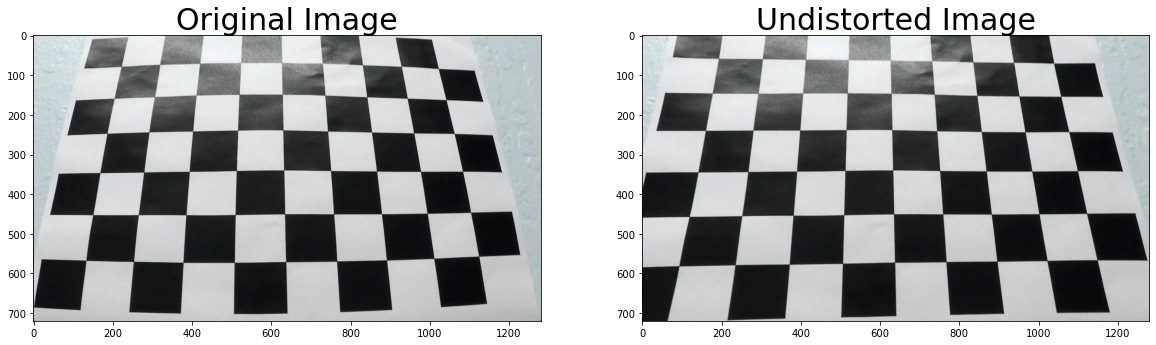

In [4]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/test.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

### Camera Calibration using 9x6 chessboard images - Camera Calibration and undistort test real world image

Text(0.5, 1.0, 'Undistorted Image')

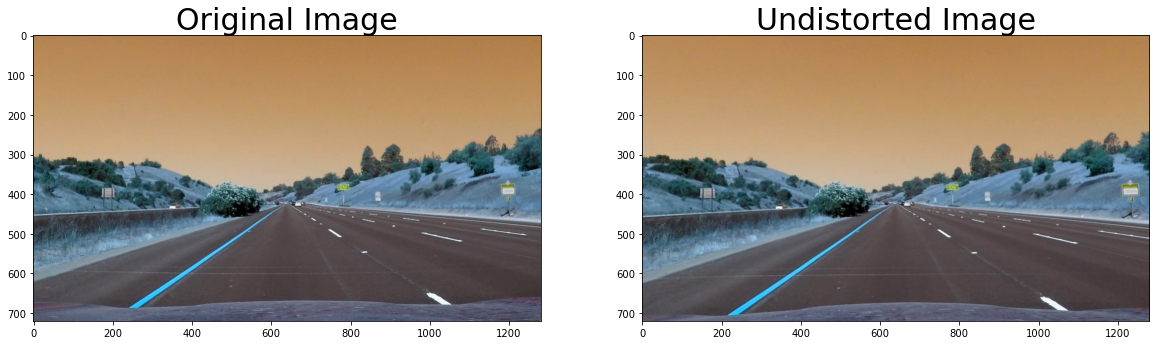

In [5]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('output_images/test2.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/test2_undist.jpg',dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Apply Sobel X gradients, HLS color transforms to create a thresholded binary image.

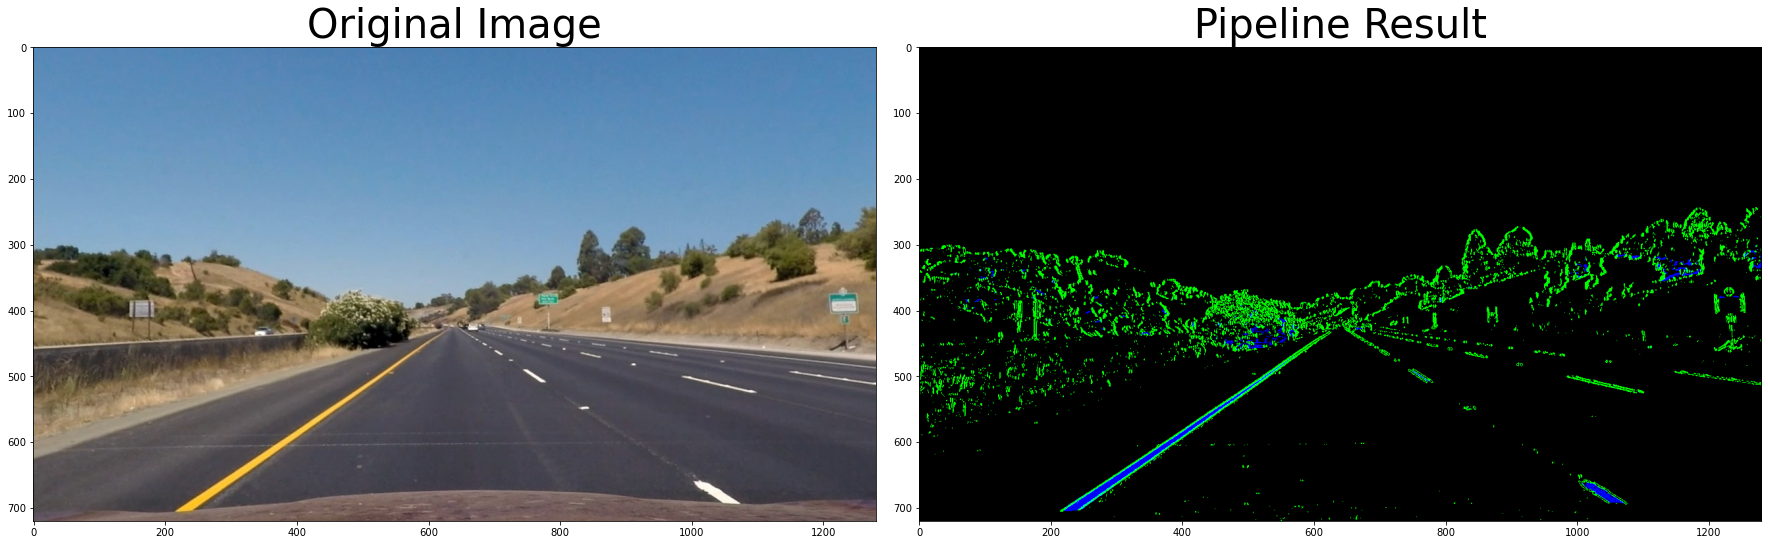

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Reading an undistorted image created earlier
image = mpimg.imread('output_images/test2_undist.jpg')

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    #hls = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
  
    # Sobel x
    #sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0,9) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    ## Writing image to output directory
    cv2.imwrite('output_images/test2_undist_colorgradTh.jpg',s_binary)
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    ## Writing image to output directory
    cv2.imwrite('output_images/test2_undist_colorgradTh.jpg',color_binary)
    
    return color_binary
    
result = pipeline(image)

# Plot the result

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Coordinates measurements to apply perspective transform

All four lane coordinates were measured namely, top left, top right, bottom left, bottom right from original image and then expected coordinate values were arrived at through experiments to ensure only "region of interest" is visible in the bird-eye view.

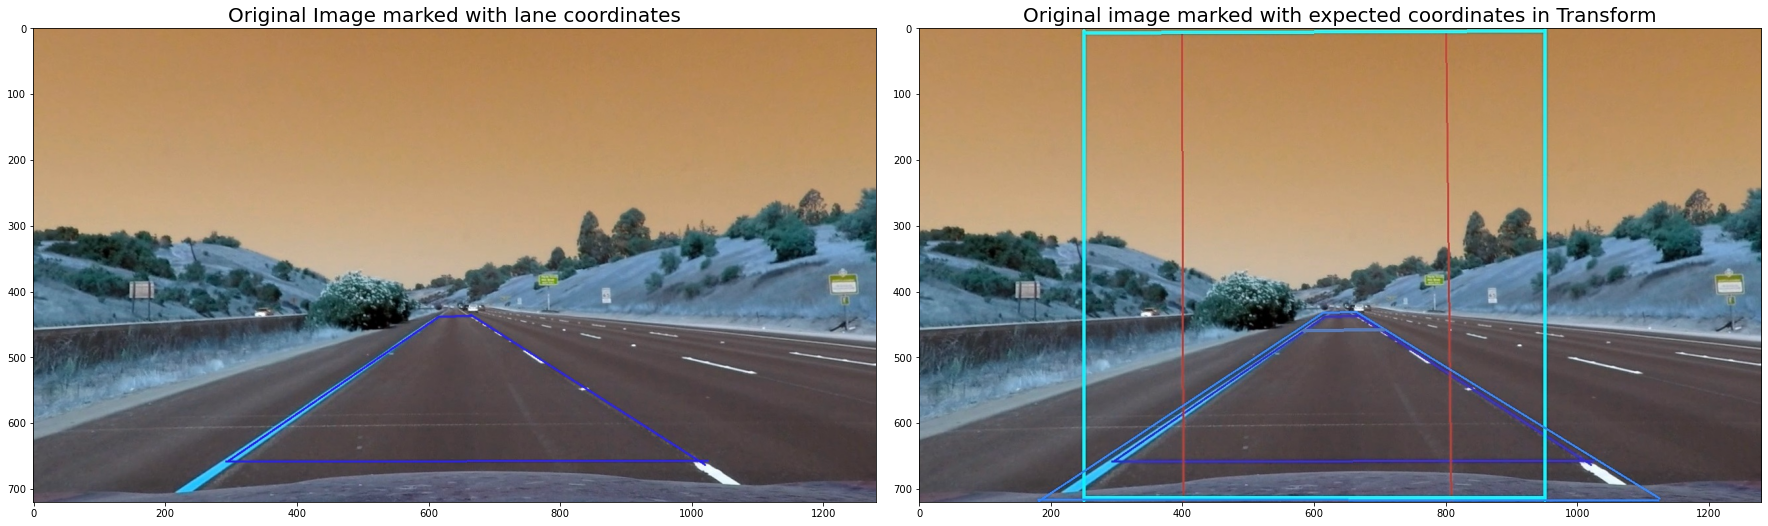

In [7]:

originalImageMarked = cv2.imread('output_images/test2_undist_Measure.jpg')
originalImageMarkedForTransform = cv2.imread('output_images/test2_undist_Measure_Perspective.jpg')

# Plot the measurement values
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(originalImageMarked)
ax1.set_title('Original Image marked with lane coordinates', fontsize=20)

ax2.imshow(originalImageMarkedForTransform)
ax2.set_title('Original image marked with expected coordinates in Transform', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#Plotting the bird eye views of lane

True

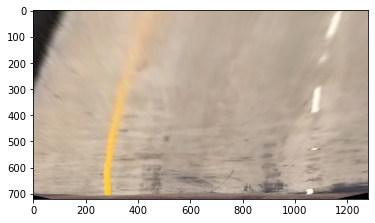

In [8]:
undist = mpimg.imread('test_images/test1.jpg')  
img_size = (undist.shape[1], undist.shape[0])  

#Temp src for experiments
src = np.float32([[570,460], [710,460],[1130,720], [210,720] ])

#Temp dest for experiments
dst = np.float32([[250,100], [1030,100],[1030,720],[250,720]])

# Given src and dst points, calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)

# Warp the image using OpenCV warpPerspective()
warped = cv2.warpPerspective(undist, M, img_size)
plt.imshow(warped)

cv2.imwrite('output_images/test2_undist_pers2.jpg',warped)

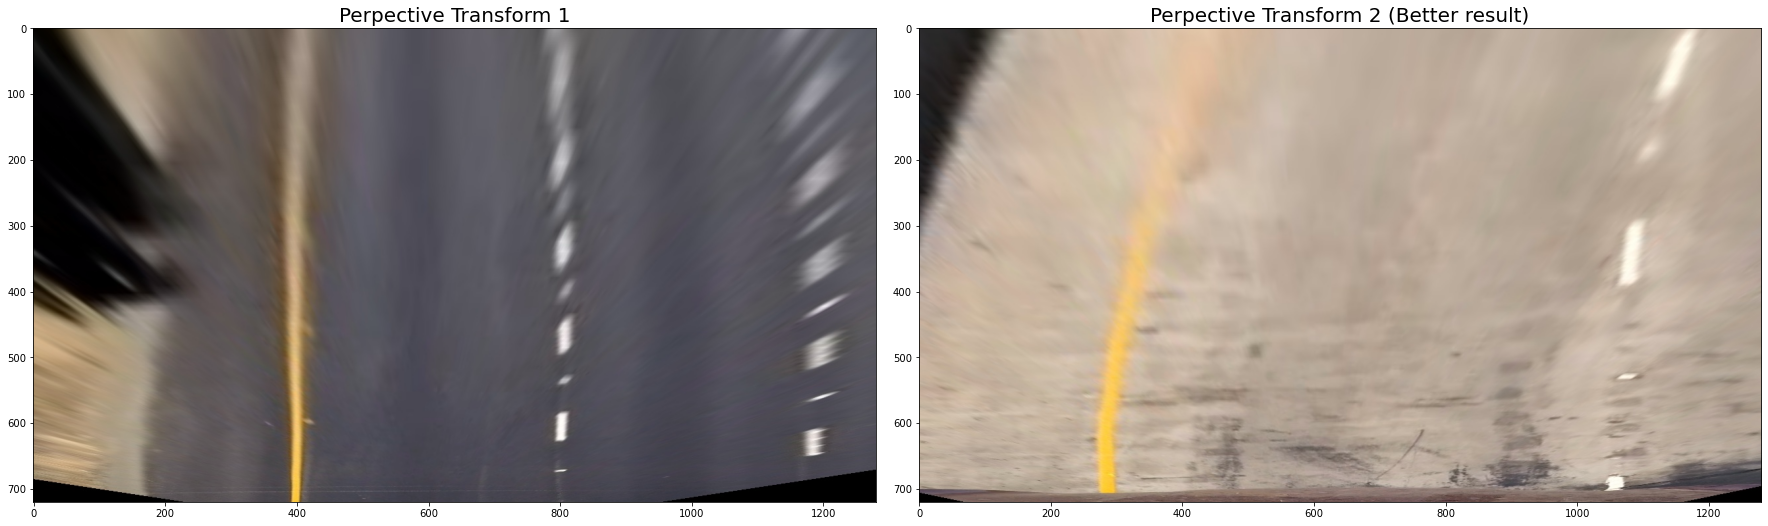

In [9]:
imagePerTransform1 = cv2.imread('output_images/test2_undist_pers1.jpg')
imagePerTransform2 = cv2.imread('output_images/test2_undist_pers2.jpg')

# Plot the measurement values
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(imagePerTransform1)
ax1.set_title('Perpective Transform 1', fontsize=20)

ax2.imshow(imagePerTransform2)
ax2.set_title('Perpective Transform 2 (Better result)', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#Plotting the bird eye views of lane

Applying perpespective transform to the binary image (Observation : Lane lines are parallel in the new perspective -bird eye view)

True

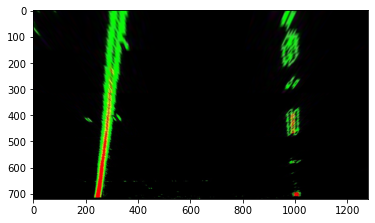

In [10]:
undist = mpimg.imread('output_images/test2_undist_colorgradTh.jpg')  
img_size = (undist.shape[1], undist.shape[0])  

# Corner Lane coordinates are grabbed 

src = np.float32([[570,460], [710,460],[1130,720], [210,720] ])
dst = np.float32([[250,100], [1030,100],[1030,720],[250,720]])

# Given src and dst points, calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)

# Given src and dst points, calculate the perspective transform matrix
Minv = cv2.getPerspectiveTransform(dst,src)

# Warp the image using OpenCV warpPerspective()
warped = cv2.warpPerspective(undist, M, img_size)

#warped_inv = cv2.warpPerspective(warped, Minv, img_size)
#plt.imshow(warped_inv)
#plt.imshow(undist)

plt.imshow(warped)

cv2.imwrite('output_images/test2_undist_colorgradTh_pers.jpg',warped)

## Pipeline function definitions

True

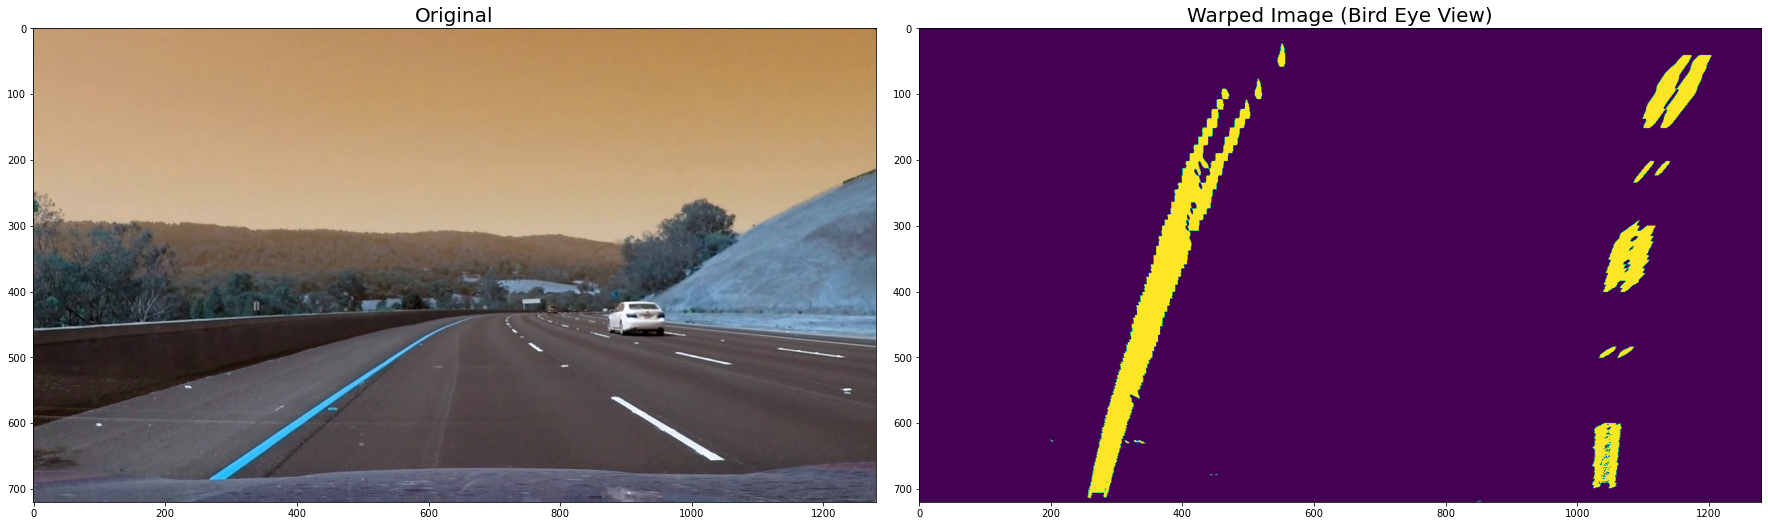

In [11]:
## Read Image
## Gaussian Blur
## Undistort Image
## Apply color,gradient and perpective transforms

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Undistort images using camera matrix and distortion matrix
def undistortImage(img,mtx,dist):
     ## Undistort image
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

## Apply Gaussian blur
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def applyPerspectiveTransform(image,M,img_size):
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(image, M, img_size)
    return warped


## Apply gradient and color thresholding
def gradientColorThImage(ori,img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    
    img = np.copy(img)
    
    #### Apply Gradient Thresholding
    ## Apply SobelX
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0,9) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    
    #### Apply Color Thresholding
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(ori, cv2.COLOR_RGB2HLS)    
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
      
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    ## Writing image to output directory
    #cv2.imwrite('output_images/test2_undist_colorgradTh.jpg',s_binary)
    
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(gray)
    combined_binary[(sxbinary == 1) | (s_binary == 1)] = 1
    
    ## Writing image to output directory
    #cv2.imwrite('output_images/test2_undist_colorgradTh.jpg',color_binary)
    
    return combined_binary
   

## Test undistortion on an image
img = cv2.imread('test_images/test3.jpg') ## For Project
##img = cv2.imread('test_images/test3.jpg')## Curved scenario with difference in road surface 

#img = cv2.imread('test_images/straight_lines1.jpg')
#img = cv2.imread('test_images/straight_lines2.jpg')

img_size = (img.shape[1], img.shape[0])
    
## Converting image to grayscale    
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

## Applying Gaussian blur
gray = gaussian_blur(gray, 7)    
    
## Undistort Image
dstImage = undistortImage(gray,mtx,dist)   
#plt.imshow(dstImage)

##Apply gradient threshold

processedImage = gradientColorThImage(img,dstImage,s_thresh=(160, 255), sx_thresh=(50, 255)) ##sx_thresh-20,100
#plt.imshow(processedImage)

img_size = (processedImage.shape[1], processedImage.shape[0])

warpedImage= applyPerspectiveTransform(processedImage,M,img_size)

#plt.imshow(warpedImage)

# Plot the measurement values
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original', fontsize=20)

ax2.imshow(warpedImage)
#ax2.imshow(processedImage)
ax2.set_title('Warped Image (Bird Eye View)', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Saving image for plotting of lines and further analysis
cv2.imwrite('output_images/testImage_forLaneLines.jpg',warpedImage)
#cv2.imwrite('output_images/testImage_forLaneLines.jpg',processedImage)


## Plotting historgrams for analysis and experiements

True

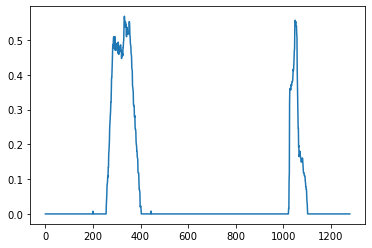

In [12]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Load our image
# `mpimg.imread` will load .jpg as 0-255, so normalize back to 0-1
img = mpimg.imread('output_images/testImage_forLaneLines.jpg')/255


def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

# Create histogram of image binary activations
histogram = hist(img)

# Visualize the resulting histogram
plt.plot(histogram)

## Saving image for plotting of lines and further analysis
cv2.imwrite('output_images/histogram_rightcurve.jpg',warpedImage)


## Find Lane Pixels : Sliding Window

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


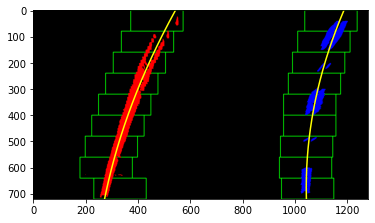

In [13]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

# Load our image
#binary_warped = mpimg.imread('warped_example.jpg')

# Load our image
# `mpimg.imread` will load .jpg as 0-255, so normalize back to 0-1
binary_warped = mpimg.imread('output_images/testImage_forLaneLines.jpg')/255
#binary_warped = cv2.cvtColor(testwarpedImage, cv2.COLOR_RGB2GRAY)/255

##plt.imshow(testgray,cmap='gray')

## Finding lane pixels
def find_lane_pixels(binary_warped):
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    #margin = 100
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

## Fitting polynomial
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    

    return out_img,left_fit,right_fit


out_img,left_fit,right_fit = fit_polynomial(binary_warped)

plt.imshow(out_img)

## Finding lanes : Search from previous frame

[ 2.41957573e-04 -5.49663393e-01  5.42268353e+02] [ 3.13733172e-04 -4.24422209e-01  1.18647359e+03]
[ 2.41957573e-04 -5.49663393e-01  5.42268353e+02] [ 3.13733172e-04 -4.24422209e-01  1.18647359e+03]
Image Height :  720
Image Width :  1280
Left Curved :  679.4086884684997
Right Curved :  523.4688996220085
Curvature :  601
Center of vehicle:  -0.09374316828628565


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


uint8 
 float64
Radius of curvature is 601meters
Vehicle is 0.09m left of center


True

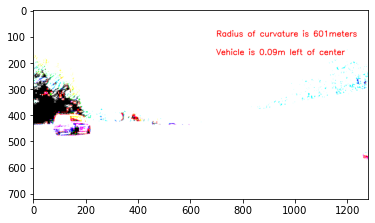

In [14]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Load our image - this should be a new frame since last time!
##binary_warped = mpimg.imread('warped_example.jpg')

binary_warped = mpimg.imread('output_images/testImage_forLaneLines.jpg')/255

# Polynomial fit values from the previous frame
#left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
#right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])
print (left_fit,right_fit)

## Fitting polynomial
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    print (left_fit,right_fit)
        
    ##Calculate readius of left and right radius of curvature
    y_eval = np.max(ploty)
    ym_per_pix = 30/img_shape[0] # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    print("Image Height : ",img_shape[0])
    print("Image Width : ",img_shape[1])
    
    ###
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    print("Left Curved : ", left_curverad)
    print("Right Curved : ",right_curverad)
    curvature = int((left_curverad + right_curverad)//2)
    print("Curvature : ",curvature)
    
    ##Calculate center of vehicle
    rightx_center = right_fit[0]*img_shape[0]**2 + right_fit[1]*img_shape[0] + right_fit[2]
    leftx_center = left_fit[0]*img_shape[0]**2 + left_fit[1]*img_shape[0] + left_fit[2]
    
    vehCenter = ((img_shape[1]/2) - ((rightx_center+leftx_center)/2) ) * xm_per_pix
    
    print("Center of vehicle: ",vehCenter)
    
    ###
    
    # Calculation of R_curve (radius of curvature)
    #left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    #right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_fitx, right_fitx, ploty,curvature, vehCenter

## Search around polynimial
def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                right_fit[1]*nonzeroy + right_fit[2] + margin)))
                
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty,curvature, vehCenter = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    
    
    ##print(left_fitx.shape,ploty[:].shape) ## All X points and Y points of lane line ploygon
    ##print((np.vstack([left_fitx-margin, ploty])).shape) ## Array of 2 rows, having 1st row as X points and 2nd row as Y points
    #print(np.transpose(np.vstack([left_fitx-margin, ploty]))) ## Array of 2 columns ,having 1st column as X points and 2nd column as Y points
    #print(np.array(np.transpose(np.vstack([left_fitx-margin, ploty])))) ## Array of 2 columns ,having 1st column as X points and 2nd column as Y points
    ##print(np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))) ## Flips the values up down for both columns
    
    '''
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    ##print("Left Window 1 \n",left_line_window1.shape)
    print(left_line_window1.shape)
    print(left_line_window2.shape)
    #print(left_line_window1)
    
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    
    #print(left_line_window1.shape,left_line_window2.shape)
    print(left_line_pts.shape)
    print(left_line_pts)
    #print(left_line_window1,"\n",left_line_window2,"\n",)
    '''
    
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    
    left_line_window3 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line_window3 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    #right_line_window3 = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
    '''left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))]) '''
    
    ##print("Left Line Window 3 \n",left_line_window3.shape,"\n",left_line_window3)
    ##print("Right Line Window 3 \n",right_line_window3.shape,"\n",right_line_window3)
    
    Lane_line_pts3 = np.hstack((left_line_window3, right_line_window3))
    ##print("Lane Line points 3\n",Lane_line_pts3.shape,"\n",Lane_line_pts3)
    cv2.fillPoly(window_img, np.int_([Lane_line_pts3]), (0,255, 0))

    # Draw the lane onto the warped blank image
    #cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    #cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    
    ##print((np.int_([left_line_pts])).shape)
   
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    ##result =out_img 

    # Plot the polynomial lines onto the image
    ##plt.plot(left_fitx, ploty, color='yellow')
    ##plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result,curvature, vehCenter

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result,curvature, vehCenter = search_around_poly(binary_warped)

## Saving image for plotting of lines and further analysis
##cv2.imwrite('output_images/test1_using1stframepolycoef.jpg',result)
oriImage = cv2.imread('test_images/straight_lines2.jpg')## Curved scenario with difference in road surface 

## Combining images 
newwarp = cv2.warpPerspective(result, Minv, (binary_warped.shape[1], binary_warped.shape[0]))

result1 = cv2.addWeighted(oriImage, 1, newwarp, 0.5, 0,dtype=cv2.CV_64F)

print(oriImage.dtype,"\n",newwarp.dtype)

txtcurvature = 'Radius of curvature is {}meters'.format(curvature)

if (vehCenter<=0):
    txtvehCenter = 'Vehicle is {:.2f}m left of center'.format(abs(vehCenter))
else:
    txtvehCenter = 'Vehicle is {:.2f}m right of center'.format(abs(vehCenter))

    
#txtcurvature = "Radius of Curvature - " + str(curvature)
#txtvehCenter = "Vehicle center - " + str(vehCenter)

font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(result1,txtcurvature,(700,100), font, 1,(255,0,0),2)
cv2.putText(result1,txtvehCenter,(700,170), font, 1,(255,0,0),2)

print(txtcurvature)
print(txtvehCenter)

#plt.imshow(newwarp)
#plt.imshow(oriImage)

# View your output
plt.imshow(result1)

## Saving image for plotting of lines and further analysis
cv2.imwrite('output_images/result.jpg',result1)


## Merge/Integration of all functions to run over video frames and create annotated video

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


## Final Result ##


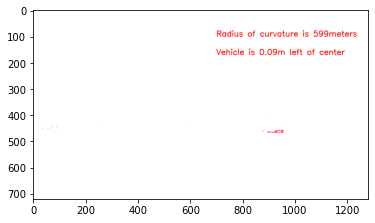

In [30]:
## Read Image
## Gaussian Blur
## Undistort Image
## Apply color,gradient and perpective transforms

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  

## Undistort images using camera matrix and distortion matrix
def undistortImage(img,mtx,dist):
     ## Undistort image
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

## Apply Gaussian blur
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def applyPerspectiveTransform(image,M,img_size):
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(image, M, img_size)
    return warped


## Apply gradient and color thresholding
def gradientColorThImage(ori,img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    
    img = np.copy(img)
    
    #### Apply Gradient Thresholding
    ## Apply SobelX
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0,9) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    
    #### Apply Color Thresholding
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(ori, cv2.COLOR_RGB2HLS)    
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
      
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(gray)
    combined_binary[(sxbinary == 1) | (s_binary == 1)] = 1
    
    ## Writing image to output directory
    #cv2.imwrite('output_images/test2_undist_colorgradTh.jpg',color_binary)
    
    return combined_binary

## Finding lane pixels
def find_lane_pixels(binary_warped):
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    #margin = 100
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

## Fitting polynomial
def fit_polynomial(binary_warped):
    
    global left_fit
    global right_fit
    
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    

    return out_img,left_fit,right_fit

## Fitting polynomial
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    ##Calculate readius of left and right radius of curvature
    y_eval = np.max(ploty)
    ym_per_pix = 30/img_shape[0] # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    ###
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    curvature = int((left_curverad + right_curverad)//2)
    
    ##Calculate center of vehicle
    rightx_center = right_fit[0]*img_shape[0]**2 + right_fit[1]*img_shape[0] + right_fit[2]
    leftx_center = left_fit[0]*img_shape[0]**2 + left_fit[1]*img_shape[0] + left_fit[2]
    
    vehCenter = ((img_shape[1]/2) - ((rightx_center+leftx_center)/2) ) * xm_per_pix
    
    return left_fitx, right_fitx, ploty,curvature, vehCenter

## Search around polynimial
def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                right_fit[1]*nonzeroy + right_fit[2] + margin)))
                
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty,curvature, vehCenter = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
        
    left_line_window3 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line_window3 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    Lane_line_pts3 = np.hstack((left_line_window3, right_line_window3))
    cv2.fillPoly(window_img, np.int_([Lane_line_pts3]), (0,255, 0))
    
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result,curvature, vehCenter

def videoProcessPipeline(img):
    
    img_size = (img.shape[1], img.shape[0])

    ## Converting image to grayscale    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    ## Applying Gaussian blur
    gray = gaussian_blur(gray, 7)    

    ## Undistort Image
    dstImage = undistortImage(gray,mtx,dist)   

    ##Apply gradient threshold
    processedImage = gradientColorThImage(img,dstImage,s_thresh=(160, 255), sx_thresh=(50, 255)) ##sx_thresh-20,100

    img_size = (processedImage.shape[1], processedImage.shape[0])

    warpedImage= applyPerspectiveTransform(processedImage,M,img_size)

    ## Fitting polynomial for 1st video image
    out_img,left_fit,right_fit = fit_polynomial(warpedImage)

    # Run image through the pipeline
    # Note that in your project, you'll also want to feed in the previous fits
    result,curvature, vehCenter = search_around_poly(warpedImage) ## 2nd image

    ## Combining images 
    newwarp = cv2.warpPerspective(result, Minv, (warpedImage.shape[1], warpedImage.shape[0]))

    result1 = cv2.addWeighted(img, 1, newwarp, 0.5, 0,dtype=cv2.CV_64F)

    txtcurvature = 'Radius of curvature is {}meters'.format(curvature)

    if (vehCenter<=0):
        txtvehCenter = 'Vehicle is {:.2f}m left of center'.format(abs(vehCenter))
    else:
        txtvehCenter = 'Vehicle is {:.2f}m right of center'.format(abs(vehCenter))

    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result1,txtcurvature,(700,100), font, 1,(255,0,0),2)
    cv2.putText(result1,txtvehCenter,(700,170), font, 1,(255,0,0),2)

    # View your output
    plt.imshow(result1)
    
    return result1

## Test undistortion on an image
img = cv2.imread('test_images/test3.jpg') ## For Project

result = videoProcessPipeline(img)

print("## Final Result ##")
plt.imshow(result)


## Reading and Writing to Video - Sample

In [ ]:
from moviepy.editor import VideoFileClip
import cv2

video_output = 'output_images/challenge_video_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(videoProcessPipeline)

white_clip.write_videofile(video_output, audio=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-2.10543653e-03  2.02173170e+00 -5.79538025e+01] [ 5.42017935e-04 -5.84029198e-01  1.15548360e+03]
Left Curved :  79.91411696403691
Right Curved :  303.2705909055297
Curvature :  191
Center of vehicle:  -0.11152697443022162
uint8 
 uint8
Radius of curvature is 191meters
Vehicle is 0.11m left of center


t:   0%|                                                                                                                                 | 0/485 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_images/challenge_video_output.mp4.
Moviepy - Writing video output_images/challenge_video_output.mp4



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-2.10543653e-03  2.02173170e+00 -5.79538025e+01] [ 5.42017935e-04 -5.84029198e-01  1.15548360e+03]
Left Curved :  79.91411696403691
Right Curved :  303.2705909055297
Curvature :  191
Center of vehicle:  -0.11152697443022162
uint8 
 uint8
Radius of curvature is 191meters
Vehicle is 0.11m left of center


t:   0%|▍                                                                                                                        | 2/485 [00:00<02:27,  3.27it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-2.32744918e-03  2.29191593e+00 -1.42923500e+02] [ 6.15030180e-04 -6.56062661e-01  1.17212136e+03]
Left Curved :  72.46491356844292
Right Curved :  267.35839872961225
Curvature :  169
Center of vehicle:  -0.10384894890105742
uint8 
 uint8
Radius of curvature is 169meters
Vehicle is 0.10m left of center


t:   1%|▋                                                                                                                        | 3/485 [00:01<03:20,  2.40it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-2.48566462e-03  2.47059371e+00 -1.91452336e+02] [ 5.31468064e-04 -5.67152294e-01  1.14952381e+03]
Left Curved :  68.02214486086713
Right Curved :  309.29564007648446
Curvature :  188
Center of vehicle:  -0.09380503124870662
uint8 
 uint8
Radius of curvature is 188meters
Vehicle is 0.09m left of center


t:   1%|▉                                                                                                                        | 4/485 [00:01<03:27,  2.31it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 2.90425719e-03 -3.20484708e+00  9.99718605e+02] [ 5.38885954e-04 -5.82615871e-01  1.15793393e+03]
Left Curved :  57.840002724616674
Right Curved :  305.0243692469139
Curvature :  181
Center of vehicle:  0.17018780962167737
uint8 
 uint8
Radius of curvature is 181meters
Vehicle is 0.17m right of center


t:   1%|█▏                                                                                                                       | 5/485 [00:02<03:24,  2.34it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 5.83291035e-04 -1.26370879e+00  9.32802410e+02] [ 4.69769671e-04 -5.12473747e-01  1.14007070e+03]
Left Curved :  282.7800722190028
Right Curved :  349.81427330150535
Curvature :  316
Center of vehicle:  -0.1583820908127456
uint8 
 uint8
Radius of curvature is 316meters
Vehicle is 0.16m left of center


t:   1%|█▍                                                                                                                       | 6/485 [00:02<03:24,  2.34it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 5.78234040e-04 -1.27117931e+00  9.40879764e+02] [ 4.70803985e-04 -5.12883565e-01  1.14077251e+03]
Left Curved :  285.34066937213936
Right Curved :  349.0487322649729
Curvature :  317
Center of vehicle:  -0.16107769370022276
uint8 
 uint8
Radius of curvature is 317meters
Vehicle is 0.16m left of center


t:   1%|█▋                                                                                                                       | 7/485 [00:02<03:16,  2.44it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 8.54139366e-04 -1.60028554e+00  1.04258321e+03] [ 4.08697849e-04 -4.43817722e-01  1.12197282e+03]
Left Curved :  192.91433018388025
Right Curved :  402.0300365603103
Curvature :  297
Center of vehicle:  -0.17827788040118722
uint8 
 uint8
Radius of curvature is 297meters
Vehicle is 0.18m left of center


t:   2%|█▉                                                                                                                       | 8/485 [00:03<03:15,  2.44it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 5.03045814e-04 -1.21731386e+00  9.42654358e+02] [ 4.06165634e-04 -4.40149586e-01  1.12205760e+03]
Left Curved :  328.3892651726763
Right Curved :  404.53654351695394
Curvature :  366
Center of vehicle:  -0.1656370806298279
uint8 
 uint8
Radius of curvature is 366meters
Vehicle is 0.17m left of center


t:   2%|██▏                                                                                                                      | 9/485 [00:03<03:13,  2.46it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 1.20391769e-03 -2.12391145e+00  1.23854179e+03] [ 4.39267405e-04 -4.77755702e-01  1.13397714e+03]
Left Curved :  136.9183157756105
Right Curved :  374.07884605003466
Curvature :  255
Center of vehicle:  -0.1880280145460532
uint8 
 uint8
Radius of curvature is 255meters
Vehicle is 0.19m left of center


t:   2%|██▍                                                                                                                     | 10/485 [00:04<03:14,  2.44it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 1.55952014e-03 -2.60598725e+00  1.40411449e+03] [ 4.84938066e-04 -5.24151517e-01  1.14647507e+03]
Left Curved :  105.64180241987248
Right Curved :  338.9002835931038
Curvature :  222
Center of vehicle:  -0.20280437639086685
uint8 
 uint8
Radius of curvature is 222meters
Vehicle is 0.20m left of center


t:   2%|██▋                                                                                                                     | 11/485 [00:04<03:14,  2.44it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 9.18613210e-04 -1.84367018e+00  1.18090065e+03] [ 4.40166472e-04 -4.93852905e-01  1.14795897e+03]
Left Curved :  179.9571749707501
Right Curved :  373.2756908185213
Curvature :  276
Center of vehicle:  -0.1856194424791993
uint8 
 uint8
Radius of curvature is 276meters
Vehicle is 0.19m left of center


t:   2%|██▉                                                                                                                     | 12/485 [00:04<03:07,  2.53it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 8.32849595e-03 -8.27064463e+00  2.16679913e+03] [ 4.51616755e-04 -5.08158348e-01  1.15495223e+03]
Left Curved :  26.603996224170707
Right Curved :  363.81698295170236
Curvature :  195
Center of vehicle:  -0.7205053547701362
uint8 
 uint8
Radius of curvature is 195meters
Vehicle is 0.72m left of center


t:   3%|███▍                                                                                                                    | 14/485 [00:05<02:59,  2.63it/s, now=None]

[ 1.10013099e-02 -1.05834819e+01  2.65856272e+03] [ 4.33120716e-04 -4.89416794e-01  1.15243013e+03]
Left Curved :  25.82935090770994
Right Curved :  379.33371386899915
Curvature :  202
Center of vehicle:  -1.284731483536596
uint8 
 uint8
Radius of curvature is 202meters
Vehicle is 1.28m left of center


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-1.02050486e-03 -1.94701264e-01  4.35518299e+02] [ 3.93248684e-04 -4.53590867e-01  1.14864491e+03]
Left Curved :  171.7780922400002
Right Curved :  417.74168806199236
Curvature :  294
Center of vehicle:  1.2891242082597418
uint8 
 uint8
Radius of curvature is 294meters
Vehicle is 1.29m right of center


t:   3%|███▋                                                                                                                    | 15/485 [00:06<03:05,  2.54it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 3.93816562e-03 -4.78084808e+00  1.48411341e+03] [ 3.84966770e-04 -4.50081141e-01  1.15081986e+03]
Left Curved :  42.48727325119311
Right Curved :  426.71006621553926
Curvature :  234
Center of vehicle:  0.4498775469219141
uint8 
 uint8
Radius of curvature is 234meters
Vehicle is 0.45m right of center


t:   3%|███▉                                                                                                                    | 16/485 [00:06<03:32,  2.20it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 2.27657112e-03 -3.24623044e+00  1.13219753e+03] [ 3.51162236e-04 -4.11112388e-01  1.14174575e+03]
Left Curved :  72.13906865056535
Right Curved :  467.76570577296116
Curvature :  269
Center of vehicle:  0.7324059656743688
uint8 
 uint8
Radius of curvature is 269meters
Vehicle is 0.73m right of center


t:   4%|████▏                                                                                                                   | 17/485 [00:07<03:24,  2.28it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-2.85706556e-03  1.76290844e+00 -7.72094956e+01] [ 3.07246631e-04 -3.74191843e-01  1.13726518e+03]
Left Curved :  65.28115491233818
Right Curved :  534.5700875084243
Curvature :  299
Center of vehicle:  1.4321497579807845
uint8 
 uint8
Radius of curvature is 299meters
Vehicle is 1.43m right of center


t:   4%|████▍                                                                                                                   | 18/485 [00:07<03:25,  2.27it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 6.96702457e-07 -5.92867659e-01  7.71014737e+02] [ 3.14704849e-04 -3.82564597e-01  1.13749246e+03]
Left Curved :  237716.1010774524
Right Curved :  521.9053413285279
Curvature :  119119
Center of vehicle:  -0.23706464876454492
uint8 
 uint8
Radius of curvature is 119119meters
Vehicle is 0.24m left of center


t:   4%|████▋                                                                                                                   | 19/485 [00:07<03:19,  2.34it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 7.03097590e-06 -5.77736362e-01  7.58332932e+02] [ 2.04258561e-04 -2.85400757e-01  1.12248677e+03]
Left Curved :  23539.501849357483
Right Curved :  804.0152660994518
Curvature :  12171
Center of vehicle:  -0.23493273525843128
uint8 
 uint8
Radius of curvature is 12171meters
Vehicle is 0.23m left of center


t:   4%|████▉                                                                                                                   | 20/485 [00:08<03:14,  2.39it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 4.51289706e-04 -1.14620548e+00  9.40339459e+02] [ 1.80250351e-04 -2.54403895e-01  1.11346717e+03]
Left Curved :  366.07948776696105
Right Curved :  911.104012466633
Curvature :  638
Center of vehicle:  -0.24514679901931777
uint8 
 uint8
Radius of curvature is 638meters
Vehicle is 0.25m left of center


t:   4%|█████▏                                                                                                                  | 21/485 [00:08<03:16,  2.36it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 4.60915954e-04 -1.14763965e+00  9.37830416e+02] [ 1.63814160e-04 -2.08379629e-01  1.09573494e+03]
Left Curved :  358.3288876890824
Right Curved :  1002.536390172009
Curvature :  680
Center of vehicle:  -0.2671705671935832
uint8 
 uint8
Radius of curvature is 680meters
Vehicle is 0.27m left of center


t:   5%|█████▍                                                                                                                  | 22/485 [00:09<03:17,  2.35it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 1.02377988e-03 -1.86543966e+00  1.16806094e+03] [ 2.68105133e-04 -3.22326289e-01  1.12458591e+03]
Left Curved :  161.01131976447832
Right Curved :  612.6050782453449
Curvature :  386
Center of vehicle:  -0.283231172983611
uint8 
 uint8
Radius of curvature is 386meters
Vehicle is 0.28m left of center


t:   5%|█████▋                                                                                                                  | 23/485 [00:09<03:16,  2.35it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 2.16876050e-04 -8.74486722e-01  8.64081798e+02] [ 9.08019812e-06 -3.47665012e-02  1.05191378e+03]
Left Curved :  763.0311364586374
Right Curved :  18086.45503815871
Curvature :  9424
Center of vehicle:  -0.26023942782407344
uint8 
 uint8
Radius of curvature is 9424meters
Vehicle is 0.26m left of center


t:   5%|█████▉                                                                                                                  | 24/485 [00:10<03:17,  2.33it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 1.22761180e-04 -7.71236590e-01  8.39836928e+02] [-2.00408624e-04  2.39945453e-01  9.61502942e+02]
Left Curved :  1349.2114469483881
Right Curved :  819.5054147657379
Curvature :  1084
Center of vehicle:  -0.2604742290920113
uint8 
 uint8
Radius of curvature is 1084meters
Vehicle is 0.26m left of center


t:   5%|██████▏                                                                                                                 | 25/485 [00:10<03:14,  2.37it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 1.14574298e-04 -7.59134198e-01  8.38707595e+02] [3.55612513e-06 2.85562147e-02 1.01303155e+03]
Left Curved :  1445.6054680620632
Right Curved :  46182.63272236927
Curvature :  23814
Center of vehicle:  -0.2826847869106914
uint8 
 uint8
Radius of curvature is 23814meters
Vehicle is 0.28m left of center


t:   5%|██████▍                                                                                                                 | 26/485 [00:10<03:05,  2.47it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 5.76792335e-06 -6.35144265e-01  8.08701757e+02] [ 1.43220861e-04 -1.18411515e-01  1.04906895e+03]
Left Curved :  28742.912625976
Right Curved :  1146.879760038786
Curvature :  14944
Center of vehicle:  -0.2971795806103349
uint8 
 uint8
Radius of curvature is 14944meters
Vehicle is 0.30m left of center


t:   6%|██████▋                                                                                                                 | 27/485 [00:11<03:06,  2.45it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-1.27141431e-04 -4.74157880e-01  7.61513844e+02] [ 2.52768549e-04 -2.42883077e-01  1.08534397e+03]
Left Curved :  1305.1670601008373
Right Curved :  649.9399831413157
Curvature :  977
Center of vehicle:  -0.30581403678469227
uint8 
 uint8
Radius of curvature is 977meters
Vehicle is 0.31m left of center


t:   6%|██████▉                                                                                                                 | 28/485 [00:11<03:29,  2.18it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-1.48064981e-04 -4.40314581e-01  7.52660224e+02] [ 1.10882549e-03 -1.27557830e+00  1.38997669e+03]
Left Curved :  1120.5974232319772
Right Curved :  148.47248978707412
Curvature :  634
Center of vehicle:  -0.33102389378430397
uint8 
 uint8
Radius of curvature is 634meters
Vehicle is 0.33m left of center


t:   6%|███████▏                                                                                                                | 29/485 [00:12<03:44,  2.03it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-2.96075962e-04 -2.49861581e-01  6.93672365e+02] [ 1.80574584e-03 -2.15853206e+00  1.66771487e+03]
Left Curved :  560.8006316247898
Right Curved :  91.36850174331447
Curvature :  326
Center of vehicle:  -0.34345693742755434
uint8 
 uint8
Radius of curvature is 326meters
Vehicle is 0.34m left of center


t:   6%|███████▍                                                                                                                | 30/485 [00:12<03:41,  2.06it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-7.67470323e-04  3.71253704e-01  4.91196100e+02] [ 1.35741129e-03 -1.66529493e+00  1.53623827e+03]
Left Curved :  216.7609650066372
Right Curved :  121.22530738644197
Curvature :  168
Center of vehicle:  -0.32123950719354916
uint8 
 uint8
Radius of curvature is 168meters
Vehicle is 0.32m left of center


t:   6%|███████▋                                                                                                                | 31/485 [00:13<03:27,  2.18it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-8.53913087e-04  5.16138476e-01  4.35933911e+02] [-1.31358815e-03  1.67850647e+00  4.96448413e+02]
Left Curved :  194.67940589366538
Right Curved :  125.15513731927979
Curvature :  159
Center of vehicle:  -0.2877913987104694
uint8 
 uint8
Radius of curvature is 159meters
Vehicle is 0.29m left of center


t:   7%|███████▉                                                                                                                | 32/485 [00:13<03:21,  2.25it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-8.89466880e-04  5.99230253e-01  3.98297070e+02] [ 7.30974708e-04 -1.02832298e+00  1.38968192e+03]
Left Curved :  186.69864495874594
Right Curved :  224.6709621048526
Curvature :  205
Center of vehicle:  -0.3088704006919946
uint8 
 uint8
Radius of curvature is 205meters
Vehicle is 0.31m left of center


t:   7%|████████▏                                                                                                               | 33/485 [00:14<03:18,  2.27it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-8.77806380e-04  6.18371848e-01  3.81895503e+02] [-7.29232443e-04  7.80851239e-01  8.38240898e+02]
Left Curved :  188.96326201511258
Right Curved :  225.5948489884573
Curvature :  207
Center of vehicle:  -0.3025756869104341
uint8 
 uint8
Radius of curvature is 207meters
Vehicle is 0.30m left of center


t:   7%|████████▍                                                                                                               | 34/485 [00:14<03:19,  2.26it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 1.44872235e-03 -2.42288953e+00  1.37275891e+03] [-3.55355836e-03  4.43152567e+00 -3.32819202e+02]
Left Curved :  113.67547710916828
Right Curved :  46.729234765587876
Curvature :  80
Center of vehicle:  -0.3039569605171
uint8 
 uint8
Radius of curvature is 80meters
Vehicle is 0.30m left of center


t:   7%|████████▋                                                                                                               | 35/485 [00:15<03:16,  2.29it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 1.84928482e-03 -3.01196486e+00  1.58622530e+03] [-5.61458466e-03  7.25326771e+00 -1.28544653e+03]
Left Curved :  89.07232639243898
Right Curved :  29.72665346005148
Curvature :  59
Center of vehicle:  -0.3239756791722067
uint8 
 uint8
Radius of curvature is 59meters
Vehicle is 0.32m left of center


t:   7%|████████▉                                                                                                               | 36/485 [00:15<03:18,  2.26it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 3.62139648e-04 -1.17178049e+00  1.02459873e+03] [2.52945084e-04 1.47716772e-01 8.39682988e+02]
Left Curved :  458.13757105635966
Right Curved :  653.3623985658876
Curvature :  555
Center of vehicle:  -0.43822738435936265
uint8 
 uint8
Radius of curvature is 555meters
Vehicle is 0.44m left of center


t:   8%|█████████▏                                                                                                              | 37/485 [00:15<03:13,  2.31it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 1.01988487e-03 -2.02732771e+00  1.30671541e+03] [-5.31601028e-03  7.31697612e+00 -1.46066468e+03]
Left Curved :  162.24847106947684
Right Curved :  30.972845653122913
Curvature :  96
Center of vehicle:  -0.38978489439697184
uint8 
 uint8
Radius of curvature is 96meters
Vehicle is 0.39m left of center


t:   8%|█████████▍                                                                                                              | 38/485 [00:16<03:12,  2.33it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-3.73792742e-04 -2.27374732e-01  7.32602916e+02] [-4.30808715e-03  6.13055476e+00 -1.12145451e+03]
Left Curved :  445.57179103969696
Right Curved :  38.12439273029741
Curvature :  241
Center of vehicle:  -0.40792894241592953
uint8 
 uint8
Radius of curvature is 241meters
Vehicle is 0.41m left of center


t:   8%|█████████▋                                                                                                              | 39/485 [00:16<03:04,  2.42it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-1.52809181e-04 -4.73944220e-01  8.03257031e+02] [-6.41401968e-03  8.91688111e+00 -2.04003054e+03]
Left Curved :  1087.2253684613943
Right Curved :  25.662414349713597
Curvature :  556
Center of vehicle:  -0.4172991165370072
uint8 
 uint8
Radius of curvature is 556meters
Vehicle is 0.42m left of center


t:   8%|█████████▉                                                                                                              | 40/485 [00:17<03:09,  2.35it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-7.91672369e-04  2.89107834e-01  5.78822550e+02] [ 1.65961297e-03 -1.35865614e+00  1.21065236e+03]
Left Curved :  211.06534934422405
Right Curved :  101.48919920861609
Curvature :  156
Center of vehicle:  -0.5003999811970835
uint8 
 uint8
Radius of curvature is 156meters
Vehicle is 0.50m left of center


t:   8%|██████████▏                                                                                                             | 41/485 [00:17<03:14,  2.28it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-4.35465510e-04 -1.23402907e-01  6.99723721e+02] [ 2.40709337e-03 -2.14435866e+00  1.38996966e+03]
Left Curved :  382.2559935993428
Right Curved :  71.10274174304753
Curvature :  226
Center of vehicle:  -0.5259204792387554
uint8 
 uint8
Radius of curvature is 226meters
Vehicle is 0.53m left of center


t:   9%|██████████▍                                                                                                             | 42/485 [00:18<03:13,  2.30it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 6.07171392e-05 -7.47322667e-01  8.98814937e+02] [ 2.65680737e-03 -2.61301313e+00  1.55560531e+03]
Left Curved :  2733.275223378777
Right Curved :  64.0017871525574
Curvature :  1398
Center of vehicle:  -0.43274982105137594
uint8 
 uint8
Radius of curvature is 1398meters
Vehicle is 0.43m left of center


t:   9%|██████████▋                                                                                                             | 43/485 [00:18<03:16,  2.25it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 2.36396025e-04 -9.70643665e-01  9.74641709e+02] [ 2.30088619e-04 -1.63379079e-01  9.62662013e+02]
Left Curved :  701.3916683512733
Right Curved :  714.2376163411027
Curvature :  707
Center of vehicle:  -0.21838717526991006
uint8 
 uint8
Radius of curvature is 707meters
Vehicle is 0.22m left of center


t:   9%|██████████▉                                                                                                             | 44/485 [00:18<03:15,  2.26it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 1.09066510e-04 -8.05431698e-01  9.25391912e+02] [ 1.11182012e-03 -1.08823112e+00  1.19334891e+03]
Left Curved :  1521.0647114857893
Right Curved :  148.6402414762066
Curvature :  834
Center of vehicle:  -0.2859868031576679
uint8 
 uint8
Radius of curvature is 834meters
Vehicle is 0.29m left of center


t:   9%|███████████▏                                                                                                            | 45/485 [00:19<03:16,  2.23it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-2.74478644e-04 -3.18433740e-01  7.76814737e+02] [ 9.10425384e-04 -9.13728278e-01  1.15665861e+03]
Left Curved :  605.6825459438346
Right Curved :  181.0660153166808
Curvature :  393
Center of vehicle:  -0.2536917917523256
uint8 
 uint8
Radius of curvature is 393meters
Vehicle is 0.25m left of center


t:   9%|███████████▍                                                                                                            | 46/485 [00:19<03:12,  2.28it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-2.00298513e-04 -3.82718701e-01  7.89448317e+02] [ 6.79585390e-04 -7.07028230e-01  1.11726461e+03]
Left Curved :  828.8303908760579
Right Curved :  242.08329406667832
Curvature :  535
Center of vehicle:  -0.23933040789000262
uint8 
 uint8
Radius of curvature is 535meters
Vehicle is 0.24m left of center


t:  10%|███████████▋                                                                                                            | 47/485 [00:20<03:15,  2.23it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 6.90051979e-03 -9.46499811e+00  3.67415382e+03] [ 5.53352612e-04 -5.87106300e-01  1.09183121e+03]
Left Curved :  23.919764500396195
Right Curved :  297.09678720325115
Curvature :  160
Center of vehicle:  -0.29747289095873336
uint8 
 uint8
Radius of curvature is 160meters
Vehicle is 0.30m left of center


t:  10%|███████████▉                                                                                                            | 48/485 [00:20<03:14,  2.25it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 1.10881147e-02 -1.53305880e+01  5.71708373e+03] [ 6.21171544e-04 -6.58514738e-01  1.10810578e+03]
Left Curved :  14.9461027696481
Right Curved :  264.73395536339297
Curvature :  139
Center of vehicle:  -0.27255660387823966
uint8 
 uint8
Radius of curvature is 139meters
Vehicle is 0.27m left of center


t:  10%|████████████                                                                                                            | 49/485 [00:21<03:16,  2.21it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-5.89825612e-04 -4.80879726e-02  7.43692076e+02] [ 6.38560629e-04 -6.79421058e-01  1.11147248e+03]
Left Curved :  283.8490085313268
Right Curved :  257.5368592589444
Curvature :  270
Center of vehicle:  -0.20250176515178753
uint8 
 uint8
Radius of curvature is 270meters
Vehicle is 0.20m left of center


t:  10%|████████████▎                                                                                                           | 50/485 [00:21<03:44,  1.94it/s, now=None]

[-5.61750824e-03  6.28610016e+00 -1.23473183e+03] [ 1.24984977e-03 -1.22422188e+00  1.22875549e+03]
Left Curved :  31.5297051103051
Right Curved :  132.44017057595735
Curvature :  81
Center of vehicle:  -0.24943781183698768
uint8 
 uint8
Radius of curvature is 81meters
Vehicle is 0.25m left of center


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  11%|████████████▌                                                                                                           | 51/485 [00:22<04:00,  1.80it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 6.56779064e-04 -1.50881767e+00  1.17785807e+03] [ 4.96033752e-04 -5.52895300e-01  1.08317773e+03]
Left Curved :  251.97365178274592
Right Curved :  331.28538545022263
Curvature :  291
Center of vehicle:  -0.24901164949688942
uint8 
 uint8
Radius of curvature is 291meters
Vehicle is 0.25m left of center


t:  11%|████████████▊                                                                                                           | 52/485 [00:23<03:55,  1.84it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 6.31053638e-04 -1.48904954e+00  1.18008660e+03] [ 4.64358763e-04 -5.27207194e-01  1.07817603e+03]
Left Curved :  262.36989637850155
Right Curved :  353.83209597972245
Curvature :  308
Center of vehicle:  -0.24953744234650338
uint8 
 uint8
Radius of curvature is 308meters
Vehicle is 0.25m left of center


t:  11%|█████████████                                                                                                           | 53/485 [00:23<03:41,  1.95it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 2.89233755e-04 -1.06661886e+00  1.05602985e+03] [ 4.08359490e-04 -4.68474874e-01  1.06406466e+03]
Left Curved :  573.6125332535337
Right Curved :  402.2990351392212
Curvature :  487
Center of vehicle:  -0.254928305432372
uint8 
 uint8
Radius of curvature is 487meters
Vehicle is 0.25m left of center


t:  11%|█████████████▎                                                                                                          | 54/485 [00:23<03:26,  2.09it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 8.74279657e-05 -8.08493917e-01  9.76192794e+02] [ 1.07285882e-03 -1.13228695e+00  1.22871716e+03]
Left Curved :  1899.6010162503046
Right Curved :  153.6969701934599
Curvature :  1026
Center of vehicle:  -0.3410353540791
uint8 
 uint8
Radius of curvature is 1026meters
Vehicle is 0.34m left of center


t:  11%|█████████████▌                                                                                                          | 55/485 [00:24<03:15,  2.20it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 1.10713600e-04 -8.29104990e-01  9.85261471e+02] [ 8.85728126e-04 -9.68580366e-01  1.19453581e+03]
Left Curved :  1499.4450968473527
Right Curved :  185.83115025897297
Curvature :  842
Center of vehicle:  -0.3224793657121867
uint8 
 uint8
Radius of curvature is 842meters
Vehicle is 0.32m left of center


t:  12%|█████████████▊                                                                                                          | 56/485 [00:24<03:11,  2.24it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 5.80652132e-05 -7.54957962e-01  9.64681463e+02] [ 1.20672340e-03 -1.31844866e+00  1.28635209e+03]
Left Curved :  2859.1524741310022
Right Curved :  136.6642567773846
Curvature :  1497
Center of vehicle:  -0.35373902923178957
uint8 
 uint8
Radius of curvature is 1497meters
Vehicle is 0.35m left of center


t:  12%|██████████████                                                                                                          | 57/485 [00:25<03:06,  2.30it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 2.50462410e-04 -9.85392624e-01  1.03869132e+03] [ 1.04197124e-03 -1.15548159e+00  1.24611647e+03]
Left Curved :  661.8910951543157
Right Curved :  158.0590617797486
Curvature :  409
Center of vehicle:  -0.35249358983693846
uint8 
 uint8
Radius of curvature is 409meters
Vehicle is 0.35m left of center


t:  12%|██████████████▎                                                                                                         | 58/485 [00:25<03:03,  2.33it/s, now=None]

[ 3.58808843e-04 -1.12507179e+00  1.08888684e+03] [ 1.05829292e-03 -1.21224063e+00  1.27093957e+03]
Left Curved :  461.8049611946526
Right Curved :  155.53994291825836
Curvature :  308
Center of vehicle:  -0.34776571361007486
uint8 
 uint8
Radius of curvature is 308meters
Vehicle is 0.35m left of center


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  12%|██████████████▌                                                                                                         | 59/485 [00:26<04:01,  1.77it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 2.29889194e-04 -9.62563541e-01  1.04351740e+03] [ 1.08541287e-03 -1.25521570e+00  1.28404734e+03]
Left Curved :  721.2718900012272
Right Curved :  151.64470599216293
Curvature :  436
Center of vehicle:  -0.3504858834554317
uint8 
 uint8
Radius of curvature is 436meters
Vehicle is 0.35m left of center


t:  12%|██████████████▊                                                                                                         | 60/485 [00:26<03:55,  1.80it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 3.65794586e-04 -1.13561528e+00  1.10182365e+03] [ 8.53029709e-04 -1.02992827e+00  1.23561645e+03]
Left Curved :  452.9922617587549
Right Curved :  192.70158473794848
Curvature :  322
Center of vehicle:  -0.34380203681453414
uint8 
 uint8
Radius of curvature is 322meters
Vehicle is 0.34m left of center


t:  13%|███████████████                                                                                                         | 61/485 [00:27<03:37,  1.95it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 4.94457156e-04 -1.27800140e+00  1.14424702e+03] [ 9.39118342e-04 -1.12696279e+00  1.26424360e+03]
Left Curved :  334.71600065648806
Right Curved :  175.0841883343797
Curvature :  254
Center of vehicle:  -0.3702165707361798
uint8 
 uint8
Radius of curvature is 254meters
Vehicle is 0.37m left of center


t:  13%|███████████████▎                                                                                                        | 62/485 [00:27<03:24,  2.07it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 4.69009527e-04 -1.24347421e+00  1.13617809e+03] [ 1.05134925e-03 -1.24342525e+00  1.29492820e+03]
Left Curved :  352.89699442039205
Right Curved :  156.47742487736588
Curvature :  254
Center of vehicle:  -0.3929734598233921
uint8 
 uint8
Radius of curvature is 254meters
Vehicle is 0.39m left of center


t:  13%|███████████████▌                                                                                                        | 63/485 [00:28<03:16,  2.15it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 4.72947622e-04 -1.24977637e+00  1.14384318e+03] [ 9.04946943e-04 -1.12911583e+00  1.27619722e+03]
Left Curved :  349.96464170259424
Right Curved :  181.60654772485574
Curvature :  265
Center of vehicle:  -0.37406621273448276
uint8 
 uint8
Radius of curvature is 265meters
Vehicle is 0.37m left of center


t:  13%|███████████████▊                                                                                                        | 64/485 [00:28<03:08,  2.23it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 3.99983250e-04 -1.16844466e+00  1.12701484e+03] [ 1.62362971e-03 -1.76319640e+00  1.40951215e+03]
Left Curved :  414.07734309627585
Right Curved :  101.9466371795443
Curvature :  258
Center of vehicle:  -0.514792581339478
uint8 
 uint8
Radius of curvature is 258meters
Vehicle is 0.51m left of center


t:  13%|████████████████                                                                                                        | 65/485 [00:29<03:08,  2.23it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 2.96318403e-04 -1.03875184e+00  1.09160617e+03] [ 7.22466190e-04 -9.73775108e-01  1.24594219e+03]
Left Curved :  559.2528350239421
Right Curved :  227.33734266587166
Curvature :  393
Center of vehicle:  -0.36119106364438264
uint8 
 uint8
Radius of curvature is 393meters
Vehicle is 0.36m left of center


t:  14%|████████████████▎                                                                                                       | 66/485 [00:29<03:04,  2.27it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 2.47087300e-04 -9.78843502e-01  1.07888745e+03] [ 7.72730967e-04 -1.03971360e+00  1.26540280e+03]
Left Curved :  670.8981725610167
Right Curved :  212.5538971846859
Curvature :  441
Center of vehicle:  -0.3689505813105173
uint8 
 uint8
Radius of curvature is 441meters
Vehicle is 0.37m left of center


t:  14%|████████████████▌                                                                                                       | 67/485 [00:29<03:04,  2.27it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 3.22393704e-04 -1.06247312e+00  1.10681202e+03] [ 7.12636901e-04 -9.81824058e-01  1.25243541e+03]
Left Curved :  513.8144793812189
Right Curved :  230.4596335699701
Curvature :  372
Center of vehicle:  -0.3803423739265081
uint8 
 uint8
Radius of curvature is 372meters
Vehicle is 0.38m left of center


t:  14%|████████████████▊                                                                                                       | 68/485 [00:30<03:03,  2.27it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 3.46641208e-04 -1.08068559e+00  1.11342701e+03] [ 1.16172677e-03 -1.41629758e+00  1.35470038e+03]
Left Curved :  477.64762869863614
Right Curved :  141.5850033175473
Curvature :  309
Center of vehicle:  -0.4551990166613746
uint8 
 uint8
Radius of curvature is 309meters
Vehicle is 0.46m left of center


t:  14%|█████████████████                                                                                                       | 69/485 [00:30<03:04,  2.26it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 3.13883492e-03 -3.06248615e+00  1.16274004e+03] [ 1.13101328e-03 -1.39775481e+00  1.35377760e+03]
Left Curved :  55.002986586765985
Right Curved :  145.3864555992137
Curvature :  100
Center of vehicle:  -0.6306741198373426
uint8 
 uint8
Radius of curvature is 100meters
Vehicle is 0.63m left of center


t:  14%|█████████████████▎                                                                                                      | 70/485 [00:31<03:02,  2.27it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 3.83805935e-04 -1.12140654e+00  1.13435937e+03] [ 1.18618270e-03 -1.47959794e+00  1.38323394e+03]
Left Curved :  431.24427452438005
Right Curved :  138.62070821795976
Curvature :  284
Center of vehicle:  -0.47241649609781183
uint8 
 uint8
Radius of curvature is 284meters
Vehicle is 0.47m left of center


t:  15%|█████████████████▌                                                                                                      | 71/485 [00:31<03:31,  1.96it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-1.81163837e-03  6.84102288e-01  4.55517339e+02] [ 1.16277825e-03 -1.46300448e+00  1.38390879e+03]
Left Curved :  98.84506552224396
Right Curved :  141.38554682405135
Curvature :  120
Center of vehicle:  0.8926317172400238
uint8 
 uint8
Radius of curvature is 120meters
Vehicle is 0.89m right of center


t:  15%|█████████████████▊                                                                                                      | 72/485 [00:32<03:18,  2.08it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 1.66053310e-04 -8.21424316e-01  1.04061062e+03] [ 1.01878418e-03 -1.33463266e+00  1.36292018e+03]
Left Curved :  997.1154152493513
Right Curved :  161.26488985382716
Curvature :  579
Center of vehicle:  -0.48995805146787513
uint8 
 uint8
Radius of curvature is 579meters
Vehicle is 0.49m left of center


t:  15%|██████████████████                                                                                                      | 73/485 [00:32<03:10,  2.16it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-1.37535875e-03  1.06161691e+00  4.74421439e+02] [ 8.02579601e-04 -1.12563392e+00  1.31689827e+03]
Left Curved :  121.83386855446095
Right Curved :  204.62760451092643
Curvature :  163
Center of vehicle:  -0.4447895566711918
uint8 
 uint8
Radius of curvature is 163meters
Vehicle is 0.44m left of center


t:  15%|██████████████████▎                                                                                                     | 74/485 [00:33<03:07,  2.20it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 5.28417256e-04 -1.25032569e+00  1.17362857e+03] [ 8.24226281e-04 -1.17094274e+00  1.33923326e+03]
Left Curved :  312.5962802077985
Right Curved :  199.25054620815422
Curvature :  255
Center of vehicle:  -0.5041486991822429
uint8 
 uint8
Radius of curvature is 255meters
Vehicle is 0.50m left of center


t:  15%|██████████████████▌                                                                                                     | 75/485 [00:33<03:07,  2.19it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 6.07997443e-03 -6.91623913e+00  2.27414617e+03] [ 7.89849317e-04 -1.13575251e+00  1.33077473e+03]
Left Curved :  29.215890052890472
Right Curved :  207.92159114854942
Curvature :  118
Center of vehicle:  -0.23469509112405113
uint8 
 uint8
Radius of curvature is 118meters
Vehicle is 0.23m left of center


t:  16%|██████████████████▊                                                                                                     | 76/485 [00:34<03:02,  2.24it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 3.77674765e-03 -4.46030451e+00  1.62750887e+03] [ 8.14638260e-04 -1.16927234e+00  1.34291524e+03]
Left Curved :  44.476339967811185
Right Curved :  201.59468755931752
Curvature :  123
Center of vehicle:  -0.04572998857311456
uint8 
 uint8
Radius of curvature is 123meters
Vehicle is 0.05m left of center


t:  16%|███████████████████                                                                                                     | 77/485 [00:34<02:59,  2.28it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 4.46349623e-03 -5.44197952e+00  1.94073801e+03] [ 7.26261334e-04 -1.08926162e+00  1.32874823e+03]
Left Curved :  37.64348744032398
Right Curved :  226.13721857798456
Curvature :  131
Center of vehicle:  0.059826523340142365
uint8 
 uint8
Radius of curvature is 131meters
Vehicle is 0.06m right of center


t:  16%|███████████████████▎                                                                                                    | 78/485 [00:34<02:58,  2.28it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 4.37177448e-04 -1.34953457e+00  9.07540459e+02] [ 4.33270666e-04 -8.46065956e-01  1.28355805e+03]
Left Curved :  380.37438375100794
Right Curved :  379.4947577743449
Curvature :  379
Center of vehicle:  0.5774472859908967
uint8 
 uint8
Radius of curvature is 379meters
Vehicle is 0.58m right of center


t:  16%|███████████████████▌                                                                                                    | 79/485 [00:35<02:58,  2.27it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 4.36465448e-04 -1.36264106e+00  9.19522664e+02] [ 6.87297457e-04 -1.05896498e+00  1.32676661e+03]
Left Curved :  381.18252810327994
Right Curved :  238.9744095840806
Curvature :  310
Center of vehicle:  0.5145864569525462
uint8 
 uint8
Radius of curvature is 310meters
Vehicle is 0.51m right of center


t:  16%|███████████████████▊                                                                                                    | 80/485 [00:35<02:58,  2.26it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 5.15949716e-04 -1.43603312e+00  9.36787919e+02] [ 5.06020169e-04 -8.89645381e-01  1.29040109e+03]
Left Curved :  322.0087105800142
Right Curved :  324.7514063381466
Curvature :  323
Center of vehicle:  0.5219915779773645
uint8 
 uint8
Radius of curvature is 323meters
Vehicle is 0.52m right of center


t:  17%|████████████████████                                                                                                    | 81/485 [00:36<03:00,  2.24it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 4.89275883e-04 -1.41330489e+00  9.36439283e+02] [ 4.83034712e-04 -8.51253170e-01  1.27805520e+03]
Left Curved :  339.7421146755044
Right Curved :  340.1909051961416
Curvature :  339
Center of vehicle:  0.507273974461768
uint8 
 uint8
Radius of curvature is 339meters
Vehicle is 0.51m right of center


t:  17%|████████████████████▎                                                                                                   | 82/485 [00:36<02:58,  2.26it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 4.61961451e-04 -1.34558667e+00  9.01106764e+02] [ 5.09120258e-04 -8.77548288e-01  1.29137716e+03]
Left Curved :  359.4892695209161
Right Curved :  322.7343233283174
Curvature :  341
Center of vehicle:  0.4883061415074563
uint8 
 uint8
Radius of curvature is 341meters
Vehicle is 0.49m right of center


t:  17%|████████████████████▌                                                                                                   | 83/485 [00:37<02:59,  2.24it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-6.72920642e-05 -4.99841663e-01  9.68918616e+02] [ 5.41850652e-04 -8.68714840e-01  1.28225744e+03]
Left Curved :  2461.5056461721783
Right Curved :  303.1435063449518
Curvature :  1382
Center of vehicle:  -0.6126844451748832
uint8 
 uint8
Radius of curvature is 1382meters
Vehicle is 0.61m left of center


t:  17%|████████████████████▊                                                                                                   | 84/485 [00:37<02:56,  2.28it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-2.38807096e-05 -5.34080510e-01  9.76758190e+02] [ 6.04187288e-04 -9.49628196e-01  1.31035145e+03]
Left Curved :  6930.667614346619
Right Curved :  271.85711530523673
Curvature :  3601
Center of vehicle:  -0.633414367830893
uint8 
 uint8
Radius of curvature is 3601meters
Vehicle is 0.63m left of center


t:  18%|█████████████████████                                                                                                   | 85/485 [00:37<02:52,  2.32it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-4.96305723e-05 -4.74890262e-01  9.53729591e+02] [ 5.62233648e-04 -8.64033604e-01  1.27488784e+03]
Left Curved :  3332.846600418823
Right Curved :  292.1186888239784
Curvature :  1812
Center of vehicle:  -0.661575027576927
uint8 
 uint8
Radius of curvature is 1812meters
Vehicle is 0.66m left of center


t:  18%|█████████████████████▎                                                                                                  | 86/485 [00:38<02:55,  2.27it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 2.98577266e-04 -8.71215475e-01  1.06804223e+03] [ 8.25314719e-04 -1.16610331e+00  1.35879568e+03]
Left Curved :  552.625219253424
Right Curved :  198.98884810032226
Curvature :  375
Center of vehicle:  -0.6939984107375686
uint8 
 uint8
Radius of curvature is 375meters
Vehicle is 0.69m left of center


t:  18%|█████████████████████▌                                                                                                  | 87/485 [00:38<02:51,  2.32it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 7.52835248e-05 -6.05019678e-01  9.91339322e+02] [ 6.71429423e-04 -1.01100431e+00  1.32430292e+03]
Left Curved :  2194.4505697790387
Right Curved :  244.60490432886746
Curvature :  1219
Center of vehicle:  -0.6850311057784633
uint8 
 uint8
Radius of curvature is 1219meters
Vehicle is 0.69m left of center


t:  18%|█████████████████████▊                                                                                                  | 88/485 [00:39<02:57,  2.24it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 1.93351076e-03 -2.60423573e+00  1.17327238e+03] [ 8.27783568e-04 -1.14572441e+00  1.34409216e+03]
Left Curved :  85.00069223837764
Right Curved :  198.40285413026405
Curvature :  141
Center of vehicle:  0.08232971428713098
uint8 
 uint8
Radius of curvature is 141meters
Vehicle is 0.08m right of center


t:  18%|██████████████████████                                                                                                  | 89/485 [00:39<02:54,  2.27it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 8.38968129e-04 -1.62845950e+00  9.65742910e+02] [ 8.13006627e-04 -1.14065293e+00  1.34780367e+03]
Left Curved :  196.59064575279552
Right Curved :  202.00319424432195
Curvature :  199
Center of vehicle:  0.2744095712599163
uint8 
 uint8
Radius of curvature is 199meters
Vehicle is 0.27m right of center


t:  19%|██████████████████████▎                                                                                                 | 90/485 [00:40<02:54,  2.26it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 9.05834366e-04 -1.66723101e+00  9.62813995e+02] [ 7.83421269e-04 -1.09529011e+00  1.33361990e+03]
Left Curved :  181.88105772979182
Right Curved :  209.6325560387285
Curvature :  195
Center of vehicle:  0.2560167375431442
uint8 
 uint8
Radius of curvature is 195meters
Vehicle is 0.26m right of center


t:  19%|██████████████████████▌                                                                                                 | 91/485 [00:40<03:08,  2.09it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 2.64189270e-04 -1.13762946e+00  8.61352737e+02] [-1.26919345e-03  1.34026936e+00  3.07231058e+02]
Left Curved :  630.260500827587
Right Curved :  130.1294579045528
Curvature :  380
Center of vehicle:  1.2857754790003526
uint8 
 uint8
Radius of curvature is 380meters
Vehicle is 1.29m right of center


t:  19%|██████████████████████▊                                                                                                 | 92/485 [00:41<03:22,  1.94it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 2.85210902e-04 -1.14764423e+00  8.61260505e+02] [-8.87505169e-04  1.06525845e+00  3.25769149e+02]
Left Curved :  583.3847910094377
Right Curved :  185.2419732637207
Curvature :  384
Center of vehicle:  1.2276532739183361
uint8 
 uint8
Radius of curvature is 384meters
Vehicle is 1.23m right of center


t:  19%|███████████████████████                                                                                                 | 93/485 [00:41<03:11,  2.04it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 2.94919676e-04 -1.14001737e+00  8.51285713e+02] [ 6.52423214e-04 -9.93548192e-01  1.32049327e+03]
Left Curved :  563.7561737213249
Right Curved :  251.73671691210504
Curvature :  407
Center of vehicle:  0.40511210931178543
uint8 
 uint8
Radius of curvature is 407meters
Vehicle is 0.41m right of center


t:  19%|███████████████████████▎                                                                                                | 94/485 [00:42<03:11,  2.04it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 3.10928073e-04 -1.13209833e+00  8.39941762e+02] [ 6.44694738e-04 -9.78873373e-01  1.31788114e+03]
Left Curved :  534.175913575032
Right Curved :  254.7521411495837
Curvature :  394
Center of vehicle:  0.38765918962695317
uint8 
 uint8
Radius of curvature is 394meters
Vehicle is 0.39m right of center


t:  20%|███████████████████████▌                                                                                                | 95/485 [00:43<03:38,  1.78it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 3.07264308e-04 -1.13717548e+00  8.49730789e+02] [ 7.04031994e-04 -1.02302030e+00  1.32118043e+03]
Left Curved :  540.7302791708144
Right Curved :  233.2666347996534
Curvature :  386
Center of vehicle:  0.3704591762471379
uint8 
 uint8
Radius of curvature is 386meters
Vehicle is 0.37m right of center


t:  20%|███████████████████████▊                                                                                                | 96/485 [00:43<03:23,  1.91it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 3.53256936e-04 -1.17902374e+00  8.62386613e+02] [ 6.71492080e-04 -9.91690595e-01  1.31153124e+03]
Left Curved :  469.9555422689829
Right Curved :  244.57388095982247
Curvature :  357
Center of vehicle:  0.3640973894438437
uint8 
 uint8
Radius of curvature is 357meters
Vehicle is 0.36m right of center


t:  20%|████████████████████████                                                                                                | 97/485 [00:43<03:10,  2.04it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 3.93118643e-04 -1.24967823e+00  9.01356296e+02] [ 7.68052472e-04 -1.06660090e+00  1.31822342e+03]
Left Curved :  422.4855926912112
Right Curved :  213.82967256843534
Curvature :  318
Center of vehicle:  0.3335025670552424
uint8 
 uint8
Radius of curvature is 318meters
Vehicle is 0.33m right of center


t:  20%|████████████████████████▏                                                                                               | 98/485 [00:44<03:03,  2.11it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 3.48230393e-04 -1.20706663e+00  8.95637496e+02] [ 7.44123074e-04 -1.04145081e+00  1.31010974e+03]
Left Curved :  477.2942848434797
Right Curved :  220.70269636183102
Curvature :  348
Center of vehicle:  0.3354031181568546
uint8 
 uint8
Radius of curvature is 348meters
Vehicle is 0.34m right of center


t:  20%|████████████████████████▍                                                                                               | 99/485 [00:44<02:57,  2.18it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 4.50579680e-04 -1.31883275e+00  9.31808161e+02] [ 6.84663129e-04 -9.80665149e-01  1.29201095e+03]
Left Curved :  368.4460460394817
Right Curved :  239.86509488410698
Curvature :  304
Center of vehicle:  0.32588940067458194
uint8 
 uint8
Radius of curvature is 304meters
Vehicle is 0.33m right of center


t:  21%|████████████████████████▌                                                                                              | 100/485 [00:45<03:01,  2.12it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 5.07406679e-04 -1.34730165e+00  9.27752664e+02] [ 5.82707359e-04 -8.80837784e-01  1.27206791e+03]
Left Curved :  326.6440862245497
Right Curved :  281.84649070489945
Curvature :  304
Center of vehicle:  0.31535815381539095
uint8 
 uint8
Radius of curvature is 304meters
Vehicle is 0.32m right of center


t:  21%|████████████████████████▊                                                                                              | 101/485 [00:45<02:58,  2.15it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 7.10656983e-04 -1.50182374e+00  9.44039470e+02] [ 6.32389750e-04 -9.22275046e-01  1.28233111e+03]
Left Curved :  232.37731164785652
Right Curved :  259.6933082795097
Curvature :  246
Center of vehicle:  0.27154067035007484
uint8 
 uint8
Radius of curvature is 246meters
Vehicle is 0.27m right of center


t:  21%|█████████████████████████                                                                                              | 102/485 [00:46<02:55,  2.19it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 8.59082204e-04 -1.60892111e+00  9.51756228e+02] [ 5.71619078e-04 -8.61601953e-01  1.27195830e+03]
Left Curved :  191.80963534214456
Right Curved :  287.31187249566665
Curvature :  239
Center of vehicle:  0.2468072742962417
uint8 
 uint8
Radius of curvature is 239meters
Vehicle is 0.25m right of center


t:  21%|█████████████████████████▎                                                                                             | 103/485 [00:46<02:49,  2.25it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 1.03172501e-03 -1.76711910e+00  9.82404514e+02] [ 5.02736336e-04 -7.86776002e-01  1.25593989e+03]
Left Curved :  159.4857581697959
Right Curved :  326.69785787394693
Curvature :  243
Center of vehicle:  0.2246304747198632
uint8 
 uint8
Radius of curvature is 243meters
Vehicle is 0.22m right of center


t:  21%|█████████████████████████▌                                                                                             | 104/485 [00:46<02:35,  2.45it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 1.01616530e-03 -1.71309087e+00  9.47803812e+02] [ 4.54009245e-04 -7.43297142e-01  1.25222268e+03]
Left Curved :  161.8616867498633
Right Curved :  361.79692223737675
Curvature :  261
Center of vehicle:  0.22843375414365033
uint8 
 uint8
Radius of curvature is 261meters
Vehicle is 0.23m right of center


t:  22%|█████████████████████████▊                                                                                             | 105/485 [00:47<03:31,  1.80it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 1.29758465e-03 -1.99655854e+00  1.01289199e+03] [ 4.79699011e-04 -9.99802589e-01  1.08924848e+03]
Left Curved :  126.61553928115336
Right Curved :  343.1481550740059
Curvature :  234
Center of vehicle:  1.0938671932925856
uint8 
 uint8
Radius of curvature is 234meters
Vehicle is 1.09m right of center


t:  22%|██████████████████████████                                                                                             | 106/485 [00:48<03:13,  1.96it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 4.53028369e-04 -1.16975150e+00  8.11905295e+02] [ 3.55652318e-04 -8.69813579e-01  1.05544814e+03]
Left Curved :  364.86193853342746
Right Curved :  463.1944041338498
Curvature :  414
Center of vehicle:  1.220771008645122
uint8 
 uint8
Radius of curvature is 414meters
Vehicle is 1.22m right of center


t:  22%|██████████████████████████▎                                                                                            | 107/485 [00:49<04:07,  1.52it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 6.02566269e-04 -1.33031386e+00  8.51858412e+02] [ 5.05157301e-04 -7.52165520e-01  1.24264175e+03]
Left Curved :  273.962083356314
Right Curved :  325.1053777476581
Curvature :  299
Center of vehicle:  0.29240859573602757
uint8 
 uint8
Radius of curvature is 299meters
Vehicle is 0.29m right of center


t:  22%|██████████████████████████▍                                                                                            | 108/485 [00:49<03:41,  1.70it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 5.62320685e-04 -1.30208303e+00  8.48418199e+02] [ 1.96899375e-04 -6.95888983e-01  1.00876677e+03]
Left Curved :  293.77010984515687
Right Curved :  837.4965506741947
Curvature :  565
Center of vehicle:  1.2362630458933928
uint8 
 uint8
Radius of curvature is 565meters
Vehicle is 1.24m right of center


t:  22%|██████████████████████████▋                                                                                            | 109/485 [00:49<03:18,  1.90it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 6.21088279e-04 -1.38620728e+00  8.78641303e+02] [ 4.08695506e-04 -6.34212785e-01  1.20230206e+03]
Left Curved :  265.9710577616592
Right Curved :  401.85247807850817
Curvature :  333
Center of vehicle:  0.31692923049593075
uint8 
 uint8
Radius of curvature is 333meters
Vehicle is 0.32m right of center


t:  23%|██████████████████████████▉                                                                                            | 110/485 [00:50<03:15,  1.92it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 7.14185652e-04 -1.50805263e+00  9.18974759e+02] [ 1.10770358e-03 -1.26574377e+00  1.33459907e+03]
Left Curved :  231.23534544961473
Right Curved :  148.64189013996764
Curvature :  189
Center of vehicle:  0.2090294070820971
uint8 
 uint8
Radius of curvature is 189meters
Vehicle is 0.21m right of center


t:  23%|███████████████████████████▏                                                                                           | 111/485 [00:50<03:01,  2.06it/s, now=None]

[ 6.11603469e-04 -1.39850652e+00  8.91694857e+02] [ 1.11938169e-03 -1.29318542e+00  1.34212249e+03]
Left Curved :  270.26627687965447
Right Curved :  147.06686978913265
Curvature :  208
Center of vehicle:  0.22955367088189782
uint8 
 uint8
Radius of curvature is 208meters
Vehicle is 0.23m right of center


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  23%|███████████████████████████▍                                                                                           | 112/485 [00:51<03:07,  1.99it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 7.22521017e-04 -1.53305474e+00  9.30045772e+02] [ 8.33227031e-04 -1.01037692e+00  1.27548857e+03]
Left Curved :  228.63746982399712
Right Curved :  197.26504473359984
Curvature :  212
Center of vehicle:  0.2622683182300669
uint8 
 uint8
Radius of curvature is 212meters
Vehicle is 0.26m right of center


t:  23%|███████████████████████████▋                                                                                           | 113/485 [00:51<02:53,  2.14it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 6.54052605e-04 -1.47810313e+00  9.25281951e+02] [ 6.04060522e-04 -7.67851766e-01  1.21155282e+03]
Left Curved :  252.84462588581488
Right Curved :  271.93797949570836
Curvature :  262
Center of vehicle:  0.28555254689098636
uint8 
 uint8
Radius of curvature is 262meters
Vehicle is 0.29m right of center


t:  24%|███████████████████████████▉                                                                                           | 114/485 [00:52<02:44,  2.25it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 1.18843058e-03 -2.10265971e+00  1.10132343e+03] [ 6.77651347e-04 -8.59049229e-01  1.24290175e+03]
Left Curved :  138.7052507526183
Right Curved :  242.42486270795484
Curvature :  190
Center of vehicle:  0.26647502514119986
uint8 
 uint8
Radius of curvature is 190meters
Vehicle is 0.27m right of center


t:  24%|████████████████████████████▏                                                                                          | 115/485 [00:52<02:42,  2.28it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 1.53971923e-03 -2.53352913e+00  1.23220195e+03] [ 6.29737258e-04 -8.17468945e-01  1.23611390e+03]
Left Curved :  106.9229664475231
Right Curved :  260.8349594094257
Curvature :  183
Center of vehicle:  0.2636422305001822
uint8 
 uint8
Radius of curvature is 183meters
Vehicle is 0.26m right of center


t:  24%|████████████████████████████▍                                                                                          | 116/485 [00:53<02:41,  2.29it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 1.38614203e-03 -2.34107312e+00  1.17096310e+03] [ 5.26003090e-04 -7.07325295e-01  1.21329086e+03]
Left Curved :  118.82368319075017
Right Curved :  312.23442267441004
Curvature :  215
Center of vehicle:  0.26253314917459925
uint8 
 uint8
Radius of curvature is 215meters
Vehicle is 0.26m right of center


t:  24%|████████████████████████████▋                                                                                          | 117/485 [00:53<02:39,  2.30it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 1.70434886e-03 -2.76472188e+00  1.31186895e+03] [ 4.87503937e-04 -6.63405119e-01  1.19875352e+03]
Left Curved :  96.58669069058169
Right Curved :  336.88412848354983
Curvature :  216
Center of vehicle:  0.26791299262520724
uint8 
 uint8
Radius of curvature is 216meters
Vehicle is 0.27m right of center


t:  24%|████████████████████████████▉                                                                                          | 118/485 [00:53<02:37,  2.33it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 1.92372128e-03 -3.08451685e+00  1.43004550e+03] [ 6.81566468e-04 -8.77519749e-01  1.25411022e+03]
Left Curved :  85.57803805445536
Right Curved :  241.01601990416424
Curvature :  163
Center of vehicle:  0.25881357534018984
uint8 
 uint8
Radius of curvature is 163meters
Vehicle is 0.26m right of center


t:  25%|█████████████████████████████▏                                                                                         | 119/485 [00:54<02:39,  2.29it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 4.80980082e-03 -6.36463647e+00  2.36566054e+03] [ 9.08995529e-04 -1.11696532e+00  1.31223940e+03]
Left Curved :  34.3955018747972
Right Curved :  180.82609828214407
Curvature :  107
Center of vehicle:  0.06403463968635363
uint8 
 uint8
Radius of curvature is 107meters
Vehicle is 0.06m right of center


t:  25%|█████████████████████████████▍                                                                                         | 120/485 [00:54<02:33,  2.37it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 2.09177608e-03 -3.45662191e+00  1.60930800e+03] [-2.77666055e-04  8.77732418e-02  1.00583203e+03]
Left Curved :  78.89244241999981
Right Curved :  592.8400817569034
Curvature :  335
Center of vehicle:  0.3964190100611609
uint8 
 uint8
Radius of curvature is 335meters
Vehicle is 0.40m right of center


t:  25%|█████████████████████████████▋                                                                                         | 121/485 [00:55<02:32,  2.39it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 1.36709853e-03 -2.62874087e+00  1.38225588e+03] [-5.70499441e-05 -9.03463080e-02  1.03707887e+03]
Left Curved :  121.40427609295901
Right Curved :  2880.713509813576
Curvature :  1501
Center of vehicle:  0.3680940522628856
uint8 
 uint8
Radius of curvature is 1501meters
Vehicle is 0.37m right of center


t:  25%|█████████████████████████████▉                                                                                         | 122/485 [00:55<02:38,  2.28it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-8.15219690e-04  2.21448708e-02  5.86849863e+02] [ 5.46302376e-04 -7.64617041e-01  1.22734577e+03]
Left Curved :  207.91768554779782
Right Curved :  300.6182590422047
Curvature :  254
Center of vehicle:  0.3694478109009689
uint8 
 uint8
Radius of curvature is 254meters
Vehicle is 0.37m right of center


t:  25%|██████████████████████████████▏                                                                                        | 123/485 [00:56<03:00,  2.01it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 3.14828077e-04 -1.42175694e+00  1.05328950e+03] [-2.64380119e-04  2.09081291e-01  9.35931786e+02]
Left Curved :  533.5080932411753
Right Curved :  621.6155472123272
Curvature :  577
Center of vehicle:  0.3640613983431861
uint8 
 uint8
Radius of curvature is 577meters
Vehicle is 0.36m right of center


t:  26%|██████████████████████████████▍                                                                                        | 124/485 [00:56<03:02,  1.97it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-4.82204953e-04 -4.17974877e-01  7.45012571e+02] [-9.63704504e-04  1.13271349e+00  6.37851006e+02]
Left Curved :  350.77942849026886
Right Curved :  170.67548106237848
Curvature :  260
Center of vehicle:  0.34907936730835815
uint8 
 uint8
Radius of curvature is 260meters
Vehicle is 0.35m right of center


t:  26%|██████████████████████████████▋                                                                                        | 125/485 [00:57<02:53,  2.08it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-9.22760526e-04  1.60852421e-01  5.66029955e+02] [-2.22551520e-04  2.22505213e-01  9.14161181e+02]
Left Curved :  183.8467136483375
Right Curved :  738.0962038640881
Curvature :  460
Center of vehicle:  0.3105915640748609
uint8 
 uint8
Radius of curvature is 460meters
Vehicle is 0.31m right of center


t:  26%|██████████████████████████████▉                                                                                        | 126/485 [00:57<02:47,  2.14it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-2.04915427e-03  1.67841413e+00  6.56084700e+01] [ 3.61727646e-03 -4.39571898e+00  2.30448186e+03]
Left Curved :  83.27552659435764
Right Curved :  46.114336626459995
Curvature :  64
Center of vehicle:  0.14127293111685263
uint8 
 uint8
Radius of curvature is 64meters
Vehicle is 0.14m right of center


t:  26%|███████████████████████████████▏                                                                                       | 127/485 [00:58<02:39,  2.24it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-1.78833411e-03  1.23364085e+00  2.59061469e+02] [ 3.45435983e-03 -4.33208402e+00  2.32708306e+03]
Left Curved :  95.82910779505404
Right Curved :  48.00578586212045
Curvature :  71
Center of vehicle:  0.16139089570793383
uint8 
 uint8
Radius of curvature is 71meters
Vehicle is 0.16m right of center


t:  26%|███████████████████████████████▍                                                                                       | 128/485 [00:58<02:36,  2.29it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-4.25709889e-03  4.59269647e+00 -8.69800739e+02] [ 2.29847566e-03 -2.98922360e+00  1.94261563e+03]
Left Curved :  40.77456887388772
Right Curved :  71.62255704418726
Curvature :  56
Center of vehicle:  0.17980658013696832
uint8 
 uint8
Radius of curvature is 56meters
Vehicle is 0.18m right of center


t:  27%|███████████████████████████████▋                                                                                       | 129/485 [00:58<02:34,  2.30it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 3.52260264e-03 -5.68611893e+00  2.53780802e+03] [-4.35424057e-04  6.53858147e-01  7.32541006e+02]
Left Curved :  47.0549789810231
Right Curved :  377.1720230239801
Curvature :  212
Center of vehicle:  0.08585418710688389
uint8 
 uint8
Radius of curvature is 212meters
Vehicle is 0.09m right of center


t:  27%|███████████████████████████████▉                                                                                       | 130/485 [00:59<02:34,  2.29it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-2.32672420e-02  3.05612212e+01 -9.68923706e+03] [ 8.55478452e-04 -1.12595713e+00  1.34432911e+03]
Left Curved :  8.535541293523254
Right Curved :  192.02095410487652
Curvature :  100
Center of vehicle:  0.13155086747362796
uint8 
 uint8
Radius of curvature is 100meters
Vehicle is 0.13m right of center


t:  27%|████████████████████████████████▏                                                                                      | 131/485 [00:59<02:35,  2.27it/s, now=None]

[ 1.75023969e-02 -2.42062377e+01  8.67868940e+03] [ 1.54758639e-04 -2.80604290e-01  1.09274357e+03]
Left Curved :  9.593582201552392
Right Curved :  1061.2660608448464
Curvature :  535
Center of vehicle:  -0.03799414262275814
uint8 
 uint8
Radius of curvature is 535meters
Vehicle is 0.04m left of center


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  27%|████████████████████████████████▍                                                                                      | 132/485 [01:00<02:44,  2.15it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 1.81392651e-03 -1.40302151e+00  7.32309570e+02] [ 2.77202608e-04 -3.90803014e-01  1.11124323e+03]
Left Curved :  93.7305770539287
Right Curved :  592.443809130856
Curvature :  343
Center of vehicle:  -0.9409641210961638
uint8 
 uint8
Radius of curvature is 343meters
Vehicle is 0.94m left of center


t:  27%|████████████████████████████████▋                                                                                      | 133/485 [01:00<02:45,  2.12it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-5.72972863e-01  8.10624242e+02 -2.86412001e+05] [ 1.49250183e-03 -1.30221273e+00  7.43802064e+02]
Left Curved :  2.166261192718631
Right Curved :  111.93201723924153
Curvature :  57
Center of vehicle:  1.299643403322352
uint8 
 uint8
Radius of curvature is 57meters
Vehicle is 1.30m right of center


t:  28%|████████████████████████████████▉                                                                                      | 134/485 [01:01<02:41,  2.18it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 8.85377037e-02 -1.17415854e+02  3.89725473e+04] [-5.03766415e-04 -7.64533257e-01  7.18278113e+02]
Left Curved :  7.676442680444169
Right Curved :  343.5984489431175
Curvature :  175
Center of vehicle:  2.754544516364213
uint8 
 uint8
Radius of curvature is 175meters
Vehicle is 2.75m right of center


t:  28%|█████████████████████████████████                                                                                      | 135/485 [01:01<02:37,  2.22it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-6.55641953e-02  9.19186087e+01 -3.21153483e+04] [-6.60239049e-04 -7.07278636e-01  7.20435310e+02]
Left Curved :  2.849827637230323
Right Curved :  265.39876941732393
Curvature :  134
Center of vehicle:  3.5242554105318686
uint8 
 uint8
Radius of curvature is 134meters
Vehicle is 3.52m right of center


t:  28%|█████████████████████████████████▎                                                                                     | 136/485 [01:02<02:40,  2.18it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 3.51068178e-01 -4.83783617e+02  1.66722220e+05] [ 2.94581332e-03 -8.02512165e-01  7.08723138e+02]
Left Curved :  10.848713319868523
Right Curved :  72.34485418079113
Curvature :  41
Center of vehicle:  -2.0344268784667525
uint8 
 uint8
Radius of curvature is 41meters
Vehicle is 2.03m left of center


t:  28%|█████████████████████████████████▌                                                                                     | 137/485 [01:02<02:41,  2.16it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 3.32901842e-02 -4.47460774e+01  1.51084568e+04] [ 3.34167669e-03 -1.04391999e+00  7.10614727e+02]
Left Curved :  6.140829442173275
Right Curved :  66.8511691126242
Curvature :  36
Center of vehicle:  -1.4806081385507546
uint8 
 uint8
Radius of curvature is 36meters
Vehicle is 1.48m left of center


t:  28%|█████████████████████████████████▊                                                                                     | 138/485 [01:03<02:36,  2.22it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-1.46069955e-02  2.11317253e+01 -7.53910184e+03] [ 5.26103461e-03 -1.99720325e+00  7.62813641e+02]
Left Curved :  11.247387306447157
Right Curved :  57.286444790937274
Curvature :  34
Center of vehicle:  -2.314142761733005
uint8 
 uint8
Radius of curvature is 34meters
Vehicle is 2.31m left of center


t:  29%|██████████████████████████████████                                                                                     | 139/485 [01:03<03:05,  1.87it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 2.27130071e-02 -3.04529073e+01  1.02691481e+04] [ 5.03313294e-03 -1.97262081e+00  7.64694756e+02]
Left Curved :  8.098229618361726
Right Curved :  56.74167910932951
Curvature :  32
Center of vehicle:  -2.0906628444382234
uint8 
 uint8
Radius of curvature is 32meters
Vehicle is 2.09m left of center


t:  29%|██████████████████████████████████▎                                                                                    | 140/485 [01:04<02:58,  1.93it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 1.50758676e-01 -2.10394137e+02  7.34548553e+04] [ 3.44970369e-03 -1.29066596e+00  7.35694462e+02]
Left Curved :  2.3266853418551325
Right Curved :  63.89477522784049
Curvature :  33
Center of vehicle:  -1.1605194484312067
uint8 
 uint8
Radius of curvature is 33meters
Vehicle is 1.16m left of center


t:  29%|██████████████████████████████████▌                                                                                    | 141/485 [01:04<02:49,  2.04it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-1.60648648e-04 -8.31139724e-01  7.34573151e+02] [ 3.25929138e-03 -1.28708523e+00  7.43905125e+02]
Left Curved :  1050.2381881326414
Right Curved :  65.08063610808493
Curvature :  557
Center of vehicle:  -0.7391878435808553
uint8 
 uint8
Radius of curvature is 557meters
Vehicle is 0.74m left of center


t:  29%|██████████████████████████████████▊                                                                                    | 142/485 [01:05<02:43,  2.10it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-1.18910341e-04 -8.50344887e-01  7.47103612e+02] [ 3.36896277e-03 -1.42249597e+00  7.60957803e+02]
Left Curved :  1416.019006546326
Right Curved :  63.15705646590289
Curvature :  739
Center of vehicle:  -0.7305998345890601
uint8 
 uint8
Radius of curvature is 739meters
Vehicle is 0.73m left of center


t:  29%|███████████████████████████████████                                                                                    | 143/485 [01:05<02:40,  2.14it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-1.27186919e-04 -8.46349179e-01  7.57349998e+02] [ 3.70114804e-03 -1.72984393e+00  7.96279696e+02]
Left Curved :  1324.3823716924728
Right Curved :  58.88935522000277
Curvature :  691
Center of vehicle:  -0.7175677044231571
uint8 
 uint8
Radius of curvature is 691meters
Vehicle is 0.72m left of center


t:  30%|███████████████████████████████████▎                                                                                   | 144/485 [01:06<02:39,  2.14it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 7.61116775e-05 -9.15022285e-01  7.55483708e+02] [ 3.55448415e-03 -1.63657540e+00  7.78352087e+02]
Left Curved :  2191.5960384207874
Right Curved :  60.30312441091121
Curvature :  1125
Center of vehicle:  -0.789649608613858
uint8 
 uint8
Radius of curvature is 1125meters
Vehicle is 0.79m left of center


t:  30%|███████████████████████████████████▌                                                                                   | 145/485 [01:06<02:38,  2.14it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 1.15452636e-04 -9.31291448e-01  7.56861782e+02] [ 2.97860817e-03 -1.37566272e+00  7.65138403e+02]
Left Curved :  1442.616070735066
Right Curved :  66.76140137890478
Curvature :  754
Center of vehicle:  -0.48880780393432194
uint8 
 uint8
Radius of curvature is 754meters
Vehicle is 0.49m left of center


t:  30%|███████████████████████████████████▊                                                                                   | 146/485 [01:06<02:38,  2.13it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 2.96816097e-05 -8.28251133e-01  7.10881635e+02] [ 9.01856059e-04 -2.86626143e-01  6.85914195e+02]
Left Curved :  5615.572297458709
Right Curved :  186.60317838729426
Curvature :  2901
Center of vehicle:  0.5365176554742229
uint8 
 uint8
Radius of curvature is 2901meters
Vehicle is 0.54m right of center


t:  30%|████████████████████████████████████                                                                                   | 147/485 [01:07<02:38,  2.13it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 1.09636594e-04 -8.55438967e-01  7.08216453e+02] [-5.62284603e-04  4.12143857e-01  6.62224635e+02]
Left Curved :  1515.5588407217938
Right Curved :  293.1791243230265
Curvature :  904
Center of vehicle:  1.2246580284650972
uint8 
 uint8
Radius of curvature is 904meters
Vehicle is 1.22m right of center


t:  31%|████████████████████████████████████▎                                                                                  | 148/485 [01:07<02:34,  2.18it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 9.15502367e-05 -8.45937726e-01  7.08518622e+02] [ 7.77517043e-04 -2.47006578e-01  6.77382875e+02]
Left Curved :  1815.9809214615975
Right Curved :  215.09984362476226
Curvature :  1015
Center of vehicle:  0.6091625138470785
uint8 
 uint8
Radius of curvature is 1015meters
Vehicle is 0.61m right of center


t:  31%|████████████████████████████████████▌                                                                                  | 149/485 [01:08<02:34,  2.18it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 8.79344649e-05 -8.48421822e-01  7.13008847e+02] [-6.09491699e-04  4.08069614e-01  6.63112055e+02]
Left Curved :  1891.1516999590083
Right Curved :  270.87682493110447
Curvature :  1081
Center of vehicle:  1.298456745351068
uint8 
 uint8
Radius of curvature is 1081meters
Vehicle is 1.30m right of center


t:  31%|████████████████████████████████████▊                                                                                  | 150/485 [01:08<02:28,  2.25it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 7.91029026e-05 -8.38818690e-01  7.11837299e+02] [-7.67125697e-04  4.89987914e-01  6.60386398e+02]
Left Curved :  2102.517681192306
Right Curved :  216.02627795735592
Curvature :  1159
Center of vehicle:  1.3626716223439164
uint8 
 uint8
Radius of curvature is 1159meters
Vehicle is 1.36m right of center


t:  31%|█████████████████████████████████████                                                                                  | 151/485 [01:09<02:26,  2.28it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 6.77201478e-05 -8.51784196e-01  7.29107279e+02] [-1.25564021e-03  8.26925478e-01  6.11393214e+02]
Left Curved :  2458.4714821402276
Right Curved :  133.82687997103838
Curvature :  1296
Center of vehicle:  1.5149267965006004
uint8 
 uint8
Radius of curvature is 1296meters
Vehicle is 1.51m right of center


t:  31%|█████████████████████████████████████▎                                                                                 | 152/485 [01:09<02:43,  2.04it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 7.82726334e-05 -8.59661269e-01  7.35377306e+02] [-1.16699972e-03  8.42881227e-01  5.80845292e+02]
Left Curved :  2126.4701503144347
Right Curved :  143.10219773093655
Curvature :  1134
Center of vehicle:  1.4278171940214213
uint8 
 uint8
Radius of curvature is 1134meters
Vehicle is 1.43m right of center


t:  32%|█████████████████████████████████████▌                                                                                 | 153/485 [01:10<02:42,  2.04it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 9.85572851e-05 -8.85373190e-01  7.47204041e+02] [-1.06798029e-03  7.77214349e-01  5.88041936e+02]
Left Curved :  1688.6006432332492
Right Curved :  155.91391610706935
Curvature :  922
Center of vehicle:  1.3879685060817226
uint8 
 uint8
Radius of curvature is 922meters
Vehicle is 1.39m right of center


t:  32%|█████████████████████████████████████▊                                                                                 | 154/485 [01:10<02:36,  2.11it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 7.22213984e-05 -8.44641178e-01  7.32685999e+02] [ 9.29543058e-03 -1.14056330e+01  4.46345145e+03]
Left Curved :  2304.1229879006296
Right Curved :  19.332949692146624
Curvature :  1161
Center of vehicle:  0.12651130578047115
uint8 
 uint8
Radius of curvature is 1161meters
Vehicle is 0.13m right of center


t:  32%|██████████████████████████████████████                                                                                 | 155/485 [01:11<02:53,  1.90it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 7.04975896e-05 -8.27747900e-01  7.22547179e+02] [ 1.17645807e-03 -1.23721805e+00  1.28052925e+03]
Left Curved :  2359.269091544644
Right Curved :  140.2909448331199
Curvature :  1249
Center of vehicle:  0.3099469945987932
uint8 
 uint8
Radius of curvature is 1249meters
Vehicle is 0.31m right of center


t:  32%|██████████████████████████████████████▎                                                                                | 156/485 [01:11<02:43,  2.01it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 7.70926119e-05 -8.24210449e-01  7.20900776e+02] [ 3.96254348e-04 -5.66648294e-01  1.16733905e+03]
Left Curved :  2156.4732769625243
Right Curved :  414.4478597572091
Curvature :  1285
Center of vehicle:  0.3906021506577552
uint8 
 uint8
Radius of curvature is 1285meters
Vehicle is 0.39m right of center


t:  32%|██████████████████████████████████████▌                                                                                | 157/485 [01:12<02:37,  2.09it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 2.26001441e-04 -9.01309643e-01  7.25866013e+02] [ 3.33512251e-04 -4.97929597e-01  1.15203624e+03]
Left Curved :  732.4962113744726
Right Curved :  492.41987221781255
Curvature :  612
Center of vehicle:  0.3158164038574017
uint8 
 uint8
Radius of curvature is 612meters
Vehicle is 0.32m right of center


t:  33%|██████████████████████████████████████▊                                                                                | 158/485 [01:12<02:32,  2.15it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 5.02872096e-04 -1.07833827e+00  7.56869887e+02] [ 3.66713473e-04 -5.25825897e-01  1.15452432e+03]
Left Curved :  327.57269124806476
Right Curved :  447.83392987481
Curvature :  387
Center of vehicle:  0.19242861956538573
uint8 
 uint8
Radius of curvature is 387meters
Vehicle is 0.19m right of center


t:  33%|███████████████████████████████████████                                                                                | 159/485 [01:13<02:28,  2.20it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 6.16543678e-04 -1.14776956e+00  7.63828428e+02] [ 5.16472835e-04 -9.23840280e-01  1.03418845e+03]
Left Curved :  266.80546712144184
Right Curved :  318.22939249321627
Curvature :  292
Center of vehicle:  1.020635593605381
uint8 
 uint8
Radius of curvature is 292meters
Vehicle is 1.02m right of center


t:  33%|███████████████████████████████████████▎                                                                               | 160/485 [01:13<02:23,  2.26it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 7.09238612e-04 -1.22033630e+00  7.77591546e+02] [ 5.06994418e-04 -9.23307950e-01  1.03671873e+03]
Left Curved :  231.77818765398848
Right Curved :  324.2172464848175
Curvature :  277
Center of vehicle:  1.0006343048357802
uint8 
 uint8
Radius of curvature is 277meters
Vehicle is 1.00m right of center


t:  33%|███████████████████████████████████████▌                                                                               | 161/485 [01:13<02:23,  2.25it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 5.76674193e-04 -1.11443690e+00  7.55716443e+02] [-5.82224318e-04  2.28363003e-01  7.41637221e+02]
Left Curved :  285.34177344790504
Right Curved :  284.59579754354786
Curvature :  284
Center of vehicle:  1.1192413577455205
uint8 
 uint8
Radius of curvature is 284meters
Vehicle is 1.12m right of center


t:  33%|███████████████████████████████████████▋                                                                               | 162/485 [01:14<02:28,  2.17it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 6.20098033e-04 -1.15938278e+00  7.68626310e+02] [-6.09533279e-04  2.71378231e-01  7.26270079e+02]
Left Curved :  265.29815431325596
Right Curved :  271.8153762517299
Curvature :  268
Center of vehicle:  1.107331021365739
uint8 
 uint8
Radius of curvature is 268meters
Vehicle is 1.11m right of center


t:  34%|███████████████████████████████████████▉                                                                               | 163/485 [01:14<02:24,  2.22it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 5.91812043e-04 -1.14804850e+00  7.69366437e+02] [-6.74510080e-04  3.52690147e-01  7.01825938e+02]
Left Curved :  278.0892887651083
Right Curved :  245.71826863733696
Curvature :  261
Center of vehicle:  1.1214602151337292
uint8 
 uint8
Radius of curvature is 261meters
Vehicle is 1.12m right of center


t:  34%|████████████████████████████████████████▏                                                                              | 164/485 [01:15<02:24,  2.21it/s, now=None]

[ 6.39669449e-04 -1.16964296e+00  7.66380238e+02] [ 4.24149084e-06 -1.64840250e-01  1.06342056e+03]
Left Curved :  257.12367101536597
Right Curved :  38742.65864358193
Curvature :  19499
Center of vehicle:  0.20409116119955872
uint8 
 uint8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  34%|████████████████████████████████████████▍                                                                              | 165/485 [01:15<02:34,  2.07it/s, now=None]


Radius of curvature is 19499meters
Vehicle is 0.20m right of center


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 6.19631566e-04 -1.16767527e+00  7.71227979e+02] [-1.27778815e-04  3.00939246e-03  1.01109905e+03]
Left Curved :  265.5291075509984
Right Curved :  1286.2557841758482
Curvature :  775
Center of vehicle:  0.21474781502324414
uint8 
 uint8
Radius of curvature is 775meters
Vehicle is 0.21m right of center


t:  34%|████████████████████████████████████████▋                                                                              | 166/485 [01:16<02:23,  2.22it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 6.65406945e-04 -1.22176202e+00  7.86143533e+02] [ 1.06019892e-04 -2.52061768e-01  1.07909021e+03]
Left Curved :  247.2246536911674
Right Curved :  1549.3890331676716
Curvature :  898
Center of vehicle:  0.20088810574628352
uint8 
 uint8
Radius of curvature is 898meters
Vehicle is 0.20m right of center


t:  34%|████████████████████████████████████████▉                                                                              | 167/485 [01:16<02:26,  2.17it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 6.74935587e-04 -1.21431978e+00  7.80241621e+02] [ 1.21390087e-04 -2.31613793e-01  1.06183232e+03]
Left Curved :  243.67116564443103
Right Curved :  1352.9904787136468
Curvature :  798
Center of vehicle:  0.1749122250943737
uint8 
 uint8
Radius of curvature is 798meters
Vehicle is 0.17m right of center


t:  35%|█████████████████████████████████████████▏                                                                             | 168/485 [01:17<02:26,  2.17it/s, now=None]

[ 5.55787889e-04 -1.13824089e+00  7.72347344e+02] [ 1.33766959e-04 -2.40501464e-01  1.06363268e+03]
Left Curved :  296.30470259876006
Right Curved :  1227.7764055813946
Curvature :  762
Center of vehicle:  0.2094444096028218
uint8 
 uint8
Radius of curvature is 762meters
Vehicle is 0.21m right of center


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  35%|█████████████████████████████████████████▍                                                                             | 169/485 [01:17<02:33,  2.06it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 5.89822342e-04 -1.17140970e+00  7.82412909e+02] [ 1.60457902e-04 -2.13719150e-01  1.03411079e+03]
Left Curved :  279.13679609660346
Right Curved :  1023.4950937862016
Curvature :  651
Center of vehicle:  0.1898200293562172
uint8 
 uint8
Radius of curvature is 651meters
Vehicle is 0.19m right of center


t:  35%|█████████████████████████████████████████▋                                                                             | 170/485 [01:18<02:51,  1.84it/s, now=None]

[ 5.83230545e-04 -1.21543311e+00  8.10618312e+02] [ 4.78051009e-04 -6.00043831e-01  1.14624615e+03]
Left Curved :  282.54647357500704
Right Curved :  343.5972358796404
Curvature :  313
Center of vehicle:  0.2117208038465807
uint8 
 uint8
Radius of curvature is 313meters
Vehicle is 0.21m right of center


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  35%|█████████████████████████████████████████▉                                                                             | 171/485 [01:18<02:46,  1.88it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 5.75163891e-04 -1.20430266e+00  8.07239982e+02] [ 6.55070621e-04 -7.64240202e-01  1.17570775e+03]
Left Curved :  286.51162037752346
Right Curved :  250.89202753905715
Curvature :  268
Center of vehicle:  0.20257384405091838
uint8 
 uint8
Radius of curvature is 268meters
Vehicle is 0.20m right of center


t:  35%|██████████████████████████████████████████▏                                                                            | 172/485 [01:19<02:40,  1.95it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 5.68319498e-04 -1.18447054e+00  7.94557038e+02] [ 5.76865377e-04 -6.94466341e-01  1.16541469e+03]
Left Curved :  289.9102070808991
Right Curved :  284.81350824710466
Curvature :  287
Center of vehicle:  0.20931160089320985
uint8 
 uint8
Radius of curvature is 287meters
Vehicle is 0.21m right of center


t:  36%|██████████████████████████████████████████▍                                                                            | 173/485 [01:19<02:31,  2.07it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 6.50534973e-04 -1.25550106e+00  8.10063566e+02] [ 4.54128168e-04 -5.73011405e-01  1.13871282e+03]
Left Curved :  253.073123237212
Right Curved :  361.68669123104337
Curvature :  307
Center of vehicle:  0.1984659116129193
uint8 
 uint8
Radius of curvature is 307meters
Vehicle is 0.20m right of center


t:  36%|██████████████████████████████████████████▋                                                                            | 174/485 [01:20<02:36,  1.99it/s, now=None]

[ 7.24915585e-04 -1.30654364e+00  8.12527401e+02] [ 2.82671353e-04 -6.54375777e-01  9.57276545e+02]
Left Curved :  226.92758067124794
Right Curved :  581.8431786329575
Curvature :  404
Center of vehicle:  1.0564159784633635
uint8 
 uint8
Radius of curvature is 404meters
Vehicle is 1.06m right of center


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  36%|██████████████████████████████████████████▉                                                                            | 175/485 [01:21<02:57,  1.74it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 4.96277621e-04 -1.14250235e+00  7.83899866e+02] [ 2.78067579e-04 -6.44255393e-01  9.52675213e+02]
Left Curved :  332.3872714238071
Right Curved :  591.4517811342523
Curvature :  461
Center of vehicle:  1.1323848596289936
uint8 
 uint8
Radius of curvature is 461meters
Vehicle is 1.13m right of center


t:  36%|███████████████████████████████████████████▏                                                                           | 176/485 [01:21<02:46,  1.86it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 4.87366028e-04 -1.11839347e+00  7.71303828e+02] [ 2.45919840e-04 -6.04633070e-01  9.40433324e+02]
Left Curved :  338.38717496941604
Right Curved :  668.8217780912496
Curvature :  503
Center of vehicle:  1.1330101986600734
uint8 
 uint8
Radius of curvature is 503meters
Vehicle is 1.13m right of center


t:  36%|███████████████████████████████████████████▍                                                                           | 177/485 [01:21<02:33,  2.00it/s, now=None]

[ 5.44291340e-04 -1.16092461e+00  7.71805143e+02] [ 4.25205749e-04 -5.67694752e-01  1.15005985e+03]
Left Curved :  302.7683416475284
Right Curved :  386.2466947301409
Curvature :  344
Center of vehicle:  0.264691817048829
uint8 
 uint8
Radius of curvature is 344meters
Vehicle is 0.26m right of center


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  37%|███████████████████████████████████████████▋                                                                           | 178/485 [01:22<02:45,  1.85it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 5.98276850e-04 -1.23674432e+00  7.99995897e+02] [ 3.39927578e-04 -4.65404259e-01  1.11503865e+03]
Left Curved :  275.4389726125219
Right Curved :  483.1290843976937
Curvature :  379
Center of vehicle:  0.2752462922250093
uint8 
 uint8
Radius of curvature is 379meters
Vehicle is 0.28m right of center


t:  37%|███████████████████████████████████████████▉                                                                           | 179/485 [01:23<02:40,  1.90it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 6.18560657e-04 -1.25286869e+00  8.00368563e+02] [ 2.59314629e-04 -4.21386880e-01  1.11537834e+03]
Left Curved :  266.3448808088588
Right Curved :  633.3466398518348
Curvature :  449
Center of vehicle:  0.30294162231939664
uint8 
 uint8
Radius of curvature is 449meters
Vehicle is 0.30m right of center


t:  37%|████████████████████████████████████████████▏                                                                          | 180/485 [01:23<02:31,  2.01it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 6.94689347e-04 -1.32410392e+00  8.13874752e+02] [ 4.30386865e-04 -5.26828319e-01  1.12124538e+03]
Left Curved :  237.00665026600723
Right Curved :  381.6573983193711
Curvature :  309
Center of vehicle:  0.24925201119189327
uint8 
 uint8
Radius of curvature is 309meters
Vehicle is 0.25m right of center


t:  37%|████████████████████████████████████████████▍                                                                          | 181/485 [01:23<02:20,  2.16it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 6.57541086e-04 -1.26827208e+00  7.90837651e+02] [ 5.47800362e-04 -6.60317247e-01  1.16085523e+03]
Left Curved :  250.38708145896166
Right Curved :  299.91052514524563
Curvature :  275
Center of vehicle:  0.2432549828248341
uint8 
 uint8
Radius of curvature is 275meters
Vehicle is 0.24m right of center


t:  38%|████████████████████████████████████████████▋                                                                          | 182/485 [01:24<02:33,  1.97it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 5.51915425e-04 -1.22584704e+00  8.00398842e+02] [ 4.30811428e-04 -5.31162443e-01  1.12249995e+03]
Left Curved :  298.9004590350549
Right Curved :  381.2750944160407
Curvature :  340
Center of vehicle:  0.2978564490469276
uint8 
 uint8
Radius of curvature is 340meters
Vehicle is 0.30m right of center


t:  38%|████████████████████████████████████████████▉                                                                          | 183/485 [01:24<02:27,  2.04it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 5.59137198e-04 -1.25564103e+00  8.13392261e+02] [ 3.91591236e-04 -4.95236612e-01  1.11360620e+03]
Left Curved :  295.16169410257834
Right Curved :  419.4296848398278
Curvature :  357
Center of vehicle:  0.31919323879315
uint8 
 uint8
Radius of curvature is 357meters
Vehicle is 0.32m right of center


t:  38%|█████████████████████████████████████████████▏                                                                         | 184/485 [01:25<02:24,  2.09it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 5.27478392e-04 -1.20997365e+00  7.93723116e+02] [ 1.73980327e-04 -2.62454129e-01  1.05644397e+03]
Left Curved :  312.87608307771717
Right Curved :  943.941916894729
Curvature :  628
Center of vehicle:  0.33391103011323126
uint8 
 uint8
Radius of curvature is 628meters
Vehicle is 0.33m right of center


t:  38%|█████████████████████████████████████████████▍                                                                         | 185/485 [01:25<02:17,  2.18it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 5.13536228e-04 -1.21038041e+00  7.99786973e+02] [ 4.17730408e-06 -6.97629551e-02  1.00388893e+03]
Left Curved :  321.51651817111804
Right Curved :  39317.9040457379
Curvature :  19819
Center of vehicle:  0.3426322230243852
uint8 
 uint8
Radius of curvature is 19819meters
Vehicle is 0.34m right of center


t:  38%|█████████████████████████████████████████████▋                                                                         | 186/485 [01:26<02:10,  2.28it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 5.24417350e-04 -1.22874794e+00  8.06047827e+02] [-9.32990725e-05  5.89716268e-02  9.61752842e+02]
Left Curved :  314.86488115785755
Right Curved :  1760.4584539383197
Curvature :  1037
Center of vehicle:  0.3460730546499671
uint8 
 uint8
Radius of curvature is 1037meters
Vehicle is 0.35m right of center


t:  39%|█████████████████████████████████████████████▉                                                                         | 187/485 [01:26<02:08,  2.32it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 5.67173448e-04 -1.28322715e+00  8.24296124e+02] [-9.84516018e-04  1.13099048e+00  6.50040257e+02]
Left Curved :  291.08273200089167
Right Curved :  167.13618514145028
Curvature :  229
Center of vehicle:  0.3478645258801731
uint8 
 uint8
Radius of curvature is 229meters
Vehicle is 0.35m right of center


t:  39%|██████████████████████████████████████████████▏                                                                        | 188/485 [01:27<02:06,  2.34it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 5.83233833e-04 -9.68680606e-01  1.02987223e+03] [ 5.83233833e-04 -9.68680606e-01  1.02987223e+03]
Left Curved :  281.69442261322234
Right Curved :  281.69442261322234
Curvature :  281
Center of vehicle:  0.02764103430686716
uint8 
 uint8
Radius of curvature is 281meters
Vehicle is 0.03m right of center


t:  39%|██████████████████████████████████████████████▎                                                                        | 189/485 [01:27<02:05,  2.35it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 5.11572752e-04 -9.00020401e-01  1.01455083e+03] [ 5.11572752e-04 -9.00020401e-01  1.01455083e+03]
Left Curved :  321.23261866045596
Right Curved :  321.23261866045596
Curvature :  321
Center of vehicle:  0.043684023671089305
uint8 
 uint8
Radius of curvature is 321meters
Vehicle is 0.04m right of center


t:  39%|██████████████████████████████████████████████▌                                                                        | 190/485 [01:27<02:09,  2.29it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 4.64423696e-04 -1.23063791e+00  8.32761944e+02] [ 5.19546326e-04 -9.09862416e-01  1.01673575e+03]
Left Curved :  356.32112424614166
Right Curved :  316.2985477376407
Curvature :  336
Center of vehicle:  1.2198701415347846
uint8 
 uint8
Radius of curvature is 336meters
Vehicle is 1.22m right of center


t:  39%|██████████████████████████████████████████████▊                                                                        | 191/485 [01:28<02:16,  2.15it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 5.60569996e-04 -9.68517096e-01  1.03664119e+03] [ 5.60569996e-04 -9.68517096e-01  1.03664119e+03]
Left Curved :  293.15039102612866
Right Curved :  293.15039102612866
Curvature :  293
Center of vehicle:  0.05334147771226411
uint8 
 uint8
Radius of curvature is 293meters
Vehicle is 0.05m right of center


t:  40%|███████████████████████████████████████████████                                                                        | 192/485 [01:28<02:15,  2.17it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 5.45921356e-04 -9.51978927e-01  1.03178227e+03] [ 5.45921356e-04 -9.51978927e-01  1.03178227e+03]
Left Curved :  301.0272872105772
Right Curved :  301.0272872105772
Curvature :  301
Center of vehicle:  0.0562237541054411
uint8 
 uint8
Radius of curvature is 301meters
Vehicle is 0.06m right of center


t:  40%|███████████████████████████████████████████████▎                                                                       | 193/485 [01:29<02:17,  2.12it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 5.68880947e-04 -9.83210928e-01  1.04142371e+03] [ 5.68880947e-04 -9.83210928e-01  1.04142371e+03]
Left Curved :  288.87393195441825
Right Curved :  288.87393195441825
Curvature :  288
Center of vehicle:  0.06121000637592574
uint8 
 uint8
Radius of curvature is 288meters
Vehicle is 0.06m right of center


t:  40%|███████████████████████████████████████████████▌                                                                       | 194/485 [01:29<02:13,  2.19it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 2.86525454e-04 -1.07370962e+00  8.01898154e+02] [ 5.97350352e-04 -1.02071440e+00  1.05315032e+03]
Left Curved :  579.2346014861956
Right Curved :  275.09889680980257
Curvature :  427
Center of vehicle:  1.2546583915897194
uint8 
 uint8
Radius of curvature is 427meters
Vehicle is 1.25m right of center


t:  40%|███████████████████████████████████████████████▊                                                                       | 195/485 [01:30<02:09,  2.24it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 5.76110110e-04 -1.00201574e+00  1.05003265e+03] [ 5.76110110e-04 -1.00201574e+00  1.05003265e+03]
Left Curved :  285.26868006926054
Right Curved :  285.26868006926054
Curvature :  285
Center of vehicle:  0.06746263061566588
uint8 
 uint8
Radius of curvature is 285meters
Vehicle is 0.07m right of center


t:  40%|████████████████████████████████████████████████                                                                       | 196/485 [01:30<02:07,  2.26it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 1.83702867e-04 -9.87973050e-01  7.92826411e+02] [ 6.11797925e-04 -1.04991045e+00  1.06525448e+03]
Left Curved :  905.3096655128858
Right Curved :  268.6205637426241
Curvature :  586
Center of vehicle:  1.2601344287788416
uint8 
 uint8
Radius of curvature is 586meters
Vehicle is 1.26m right of center


t:  41%|████████████████████████████████████████████████▎                                                                      | 197/485 [01:31<02:05,  2.29it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 5.29883250e-04 -9.71041950e-01  1.04721753e+03] [ 5.29883250e-04 -9.71041950e-01  1.04721753e+03]
Left Curved :  310.25709304979716
Right Curved :  310.25709304979716
Curvature :  310
Center of vehicle:  0.09113205201177689
uint8 
 uint8
Radius of curvature is 310meters
Vehicle is 0.09m right of center


t:  41%|████████████████████████████████████████████████▌                                                                      | 198/485 [01:31<02:06,  2.28it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 3.36767818e-04 -7.62435105e-01  9.91802281e+02] [ 6.07624453e-04 -7.41966201e-01  1.17637811e+03]
Left Curved :  488.5667477793477
Right Curved :  270.39002953552324
Curvature :  379
Center of vehicle:  -0.7785445054067385
uint8 
 uint8
Radius of curvature is 379meters
Vehicle is 0.78m left of center


t:  41%|████████████████████████████████████████████████▊                                                                      | 199/485 [01:31<02:05,  2.27it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 2.75936034e-04 -6.96694710e-01  9.75162160e+02] [ 3.64110347e-04 -5.00592707e-01  1.12340854e+03]
Left Curved :  596.4549024515691
Right Curved :  451.0413523596033
Curvature :  523
Center of vehicle:  -0.7619986260112928
uint8 
 uint8
Radius of curvature is 523meters
Vehicle is 0.76m left of center


t:  41%|█████████████████████████████████████████████████                                                                      | 200/485 [01:32<02:01,  2.35it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 1.18455387e-03 -1.88574239e+00  9.87188480e+02] [ 2.41903301e-04 -3.63720112e-01  1.08762547e+03]
Left Curved :  138.75145118251416
Right Curved :  678.8982366346714
Curvature :  408
Center of vehicle:  0.22549823179563147
uint8 
 uint8
Radius of curvature is 408meters
Vehicle is 0.23m right of center


t:  41%|█████████████████████████████████████████████████▎                                                                     | 201/485 [01:32<01:59,  2.39it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 4.29917833e-04 -8.46109367e-01  1.01114134e+03] [ 4.29917833e-04 -8.46109367e-01  1.01114134e+03]
Left Curved :  382.4745876566006
Right Curved :  382.4745876566006
Curvature :  382
Center of vehicle:  0.08027941144273812
uint8 
 uint8
Radius of curvature is 382meters
Vehicle is 0.08m right of center


t:  42%|█████████████████████████████████████████████████▌                                                                     | 202/485 [01:33<02:00,  2.36it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 3.57972954e-04 -7.70864756e-01  9.92151461e+02] [ 3.57972954e-04 -7.70864756e-01  9.92151461e+02]
Left Curved :  459.49505151185974
Right Curved :  459.49505151185974
Curvature :  459
Center of vehicle:  0.09143219845919894
uint8 
 uint8
Radius of curvature is 459meters
Vehicle is 0.09m right of center


t:  42%|█████████████████████████████████████████████████▊                                                                     | 203/485 [01:33<01:58,  2.39it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 2.81677108e-04 -6.85412479e-01  9.68754361e+02] [ 2.81677108e-04 -6.85412479e-01  9.68754361e+02]
Left Curved :  584.1384407365717
Right Curved :  584.1384407365717
Curvature :  584
Center of vehicle:  0.0989549727982901
uint8 
 uint8
Radius of curvature is 584meters
Vehicle is 0.10m right of center


t:  42%|██████████████████████████████████████████████████                                                                     | 204/485 [01:34<01:57,  2.39it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 3.79577331e-04 -1.14750152e+00  8.26555902e+02] [ 2.29092871e-04 -6.24305234e-01  9.51341604e+02]
Left Curved :  436.4431075303902
Right Curved :  718.3616587306028
Curvature :  577
Center of vehicle:  1.2217101913920525
uint8 
 uint8
Radius of curvature is 577meters
Vehicle is 1.22m right of center


t:  42%|██████████████████████████████████████████████████▎                                                                    | 205/485 [01:34<02:02,  2.28it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 2.34864279e-04 -6.25118915e-01  9.50248444e+02] [ 1.98527317e-04 -3.10012611e-01  1.06967500e+03]
Left Curved :  700.63547011151
Right Curved :  827.2368504065873
Curvature :  763
Center of vehicle:  -0.7698615150985606
uint8 
 uint8
Radius of curvature is 763meters
Vehicle is 0.77m left of center


t:  42%|██████████████████████████████████████████████████▌                                                                    | 206/485 [01:34<01:59,  2.34it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 3.00511241e-04 -6.98911455e-01  9.70752359e+02] [ 3.00511241e-04 -6.98911455e-01  9.70752359e+02]
Left Curved :  547.4302503647684
Right Curved :  547.4302503647684
Curvature :  547
Center of vehicle:  0.08815969282525017
uint8 
 uint8
Radius of curvature is 547meters
Vehicle is 0.09m right of center


t:  43%|██████████████████████████████████████████████████▊                                                                    | 207/485 [01:35<02:15,  2.05it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 3.41060577e-04 -7.47550694e-01  9.85212709e+02] [ 2.07797488e-04 -2.57495279e-01  1.03566347e+03]
Left Curved :  482.2863148678218
Right Curved :  790.3536083482308
Curvature :  636
Center of vehicle:  -0.7975379197744088
uint8 
 uint8
Radius of curvature is 636meters
Vehicle is 0.80m left of center


t:  43%|███████████████████████████████████████████████████                                                                    | 208/485 [01:36<02:11,  2.10it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 5.07267366e-04 -1.28189596e+00  8.58302135e+02] [ 4.68957178e-05 -1.29326395e-01  1.01799690e+03]
Left Curved :  326.1358925360142
Right Curved :  3502.279518020327
Curvature :  1914
Center of vehicle:  0.35018627874521274
uint8 
 uint8
Radius of curvature is 1914meters
Vehicle is 0.35m right of center


t:  43%|███████████████████████████████████████████████████▎                                                                   | 209/485 [01:36<02:09,  2.13it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 4.55729131e-04 -8.77614083e-01  1.02158315e+03] [ 1.78099502e-04 -2.48231553e-01  1.04368493e+03]
Left Curved :  360.790249757472
Right Curved :  922.107982160951
Curvature :  641
Center of vehicle:  -0.8014094044452689
uint8 
 uint8
Radius of curvature is 641meters
Vehicle is 0.80m left of center


t:  43%|███████████████████████████████████████████████████▌                                                                   | 210/485 [01:36<02:07,  2.16it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 3.96571489e-04 -1.14039321e+00  8.05718634e+02] [ 3.24509484e-04 -4.35280495e-01  1.10358505e+03]
Left Curved :  417.3698034235147
Right Curved :  506.08883366607233
Curvature :  461
Center of vehicle:  0.3472000864706726
uint8 
 uint8
Radius of curvature is 461meters
Vehicle is 0.35m right of center


t:  44%|███████████████████████████████████████████████████▊                                                                   | 211/485 [01:37<02:00,  2.27it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 4.76138590e-04 -9.05240305e-01  1.03072710e+03] [ 3.68096181e-05 -9.89284835e-02  1.00336401e+03]
Left Curved :  345.31879005128263
Right Curved :  4461.744573447873
Curvature :  2403
Center of vehicle:  -0.7849336626706086
uint8 
 uint8
Radius of curvature is 2403meters
Vehicle is 0.78m left of center


t:  44%|████████████████████████████████████████████████████                                                                   | 212/485 [01:37<01:57,  2.33it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 4.93421276e-04 -9.28993091e-01  1.03884205e+03] [ 3.71389255e-04 -4.76809638e-01  1.10306997e+03]
Left Curved :  333.21968593592817
Right Curved :  442.2306700069228
Curvature :  387
Center of vehicle:  -0.787708398211923
uint8 
 uint8
Radius of curvature is 387meters
Vehicle is 0.79m left of center


t:  44%|████████████████████████████████████████████████████▎                                                                  | 213/485 [01:38<01:49,  2.49it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 5.04642554e-04 -9.48542519e-01  1.04685545e+03] [ 3.06801223e-04 -4.15900845e-01  1.09126144e+03]
Left Curved :  325.8220474110823
Right Curved :  535.2953240711852
Curvature :  430
Center of vehicle:  -0.7832638945943932
uint8 
 uint8
Radius of curvature is 430meters
Vehicle is 0.78m left of center


t:  44%|████████████████████████████████████████████████████▌                                                                  | 214/485 [01:38<01:49,  2.47it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 4.64447943e-04 -9.03358312e-01  1.03449671e+03] [ 5.70431546e-04 -7.37616864e-01  1.18716620e+03]
Left Curved :  354.0689656006675
Right Curved :  287.94658671067174
Curvature :  321
Center of vehicle:  -0.7839832518773366
uint8 
 uint8
Radius of curvature is 321meters
Vehicle is 0.78m left of center


t:  44%|████████████████████████████████████████████████████▊                                                                  | 215/485 [01:38<01:52,  2.40it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 3.75168971e-04 -8.01894320e-01  1.00684970e+03] [ 3.75168971e-04 -8.01894320e-01  1.00684970e+03]
Left Curved :  438.4684606964466
Right Curved :  438.4684606964466
Curvature :  438
Center of vehicle:  0.08471211299660132
uint8 
 uint8
Radius of curvature is 438meters
Vehicle is 0.08m right of center


t:  45%|████████████████████████████████████████████████████▉                                                                  | 216/485 [01:39<01:56,  2.32it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 3.47809471e-04 -7.68278574e-01  9.97191191e+02] [ 3.47809471e-04 -7.68278574e-01  9.97191191e+02]
Left Curved :  472.9940587886095
Right Curved :  472.9940587886095
Curvature :  472
Center of vehicle:  0.08280046367547036
uint8 
 uint8
Radius of curvature is 472meters
Vehicle is 0.08m right of center


t:  45%|█████████████████████████████████████████████████████▏                                                                 | 217/485 [01:39<01:57,  2.28it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 2.77857339e-04 -6.84752999e-01  9.73241132e+02] [ 5.50998004e-05 -2.13887302e-01  1.05623467e+03]
Left Curved :  592.2077515317013
Right Curved :  2981.8367699197756
Curvature :  1787
Center of vehicle:  -0.7269436653912656
uint8 
 uint8
Radius of curvature is 1787meters
Vehicle is 0.73m left of center


t:  45%|█████████████████████████████████████████████████████▍                                                                 | 218/485 [01:40<01:54,  2.33it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 4.29536739e-04 -8.64239335e-01  1.02640423e+03] [ 4.29536739e-04 -8.64239335e-01  1.02640423e+03]
Left Curved :  382.8957517565436
Right Curved :  382.8957517565436
Curvature :  382
Center of vehicle:  0.06964588189128249
uint8 
 uint8
Radius of curvature is 382meters
Vehicle is 0.07m right of center


t:  45%|█████████████████████████████████████████████████████▋                                                                 | 219/485 [01:40<01:53,  2.35it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 3.72002617e-04 -1.17528453e+00  8.42146975e+02] [ 5.83864569e-04 -1.04775830e+00  1.08137179e+03]
Left Curved :  445.8434400854252
Right Curved :  281.5696345845174
Curvature :  363
Center of vehicle:  1.2198121052297042
uint8 
 uint8
Radius of curvature is 363meters
Vehicle is 1.22m right of center


t:  45%|█████████████████████████████████████████████████████▉                                                                 | 220/485 [01:41<01:53,  2.34it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 3.11439174e-04 -1.08702070e+00  8.08604869e+02] [ 1.65388311e-04 -2.90772223e-01  1.06730829e+03]
Left Curved :  532.5243842734138
Right Curved :  993.0438132595785
Curvature :  762
Center of vehicle:  0.39354886587042825
uint8 
 uint8
Radius of curvature is 762meters
Vehicle is 0.39m right of center


t:  46%|██████████████████████████████████████████████████████▏                                                                | 221/485 [01:41<01:55,  2.28it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 6.43803139e-04 -1.13305483e+00  1.11090597e+03] [ 6.43803139e-04 -1.13305483e+00  1.11090597e+03]
Left Curved :  255.35299316508454
Right Curved :  255.35299316508454
Curvature :  255
Center of vehicle:  0.05891434612845449
uint8 
 uint8
Radius of curvature is 255meters
Vehicle is 0.06m right of center


t:  46%|██████████████████████████████████████████████████████▍                                                                | 222/485 [01:42<02:06,  2.08it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 2.48403925e-04 -9.99557085e-01  7.75624206e+02] [ 1.52690999e-04 -2.28760548e-01  1.04177001e+03]
Left Curved :  667.7236204634188
Right Curved :  1075.5516881092085
Curvature :  871
Center of vehicle:  0.367533879881424
uint8 
 uint8
Radius of curvature is 871meters
Vehicle is 0.37m right of center


t:  46%|██████████████████████████████████████████████████████▋                                                                | 223/485 [01:42<02:00,  2.17it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 1.91937136e-04 -9.30184941e-01  7.54043048e+02] [ 5.69216883e-04 -7.30427077e-01  1.19166017e+03]
Left Curved :  864.4818092025603
Right Curved :  288.56751527720496
Curvature :  576
Center of vehicle:  0.35772443040312896
uint8 
 uint8
Radius of curvature is 576meters
Vehicle is 0.36m right of center


t:  46%|██████████████████████████████████████████████████████▉                                                                | 224/485 [01:42<01:59,  2.18it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 2.50465930e-04 -6.46540145e-01  9.61263390e+02] [ 2.14144423e-04 -3.36692145e-01  1.08512164e+03]
Left Curved :  656.9833138065281
Right Curved :  766.9123573609448
Curvature :  711
Center of vehicle:  -0.7910383011617317
uint8 
 uint8
Radius of curvature is 711meters
Vehicle is 0.79m left of center


t:  46%|███████████████████████████████████████████████████████▏                                                               | 225/485 [01:43<01:59,  2.18it/s, now=None]

[ 4.64624845e-05 -3.90295259e-01  8.81290496e+02] [ 1.94935042e-04 -3.08472873e-01  1.07155120e+03]
Left Curved :  3543.5411767189507
Right Curved :  842.4851065766087
Curvature :  2193
Center of vehicle:  -0.7792969461263602
uint8 
 uint8
Radius of curvature is 2193meters
Vehicle is 0.78m left of center


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  47%|███████████████████████████████████████████████████████▍                                                               | 226/485 [01:43<02:06,  2.06it/s, now=None]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-8.04198334e-05 -2.17517767e-01  8.23053543e+02] [-1.94707960e-04  1.59579251e-01  9.32597655e+02]
Left Curved :  2047.5912270909357
Right Curved :  843.7467458140374
Curvature :  1445
Center of vehicle:  -0.769888649322034
uint8 
 uint8
Radius of curvature is 1445meters
Vehicle is 0.77m left of center


In [22]:
print(left_fit,right_fit)

[ 2.42510401e-04 -5.50077471e-01  5.42328381e+02] [ 3.14702577e-04 -4.25186049e-01  1.18655338e+03]
